**Lab course**: Modern Methods in Material Physics, WS 2023

**Names**: Josef Hackl, Maximilian Negedly <br/>
**Supervisor**: Toma Susi <br/>
**Date**: 12.02. - 16.02.2024

# Introduction

In this experiment, we use different interatomic potentials to simulate the behaviour of a single-layer graphene lattice after a transfer of kinetic energy to an atom in the lattice, as would be the case in an electron microscope. We test this in the static-lattice approximation as well as for lattices undergoing thermal vibrations corresponding to different temperatures. In the latter case, we obtain statistical distributions of threshold energies for different temperatures that we analyse. Furthermore, we discuss the behaviour and compare the performance of the different potentials employed.

# Theoretical background

A solid with a crystalline structure that only consists of a single layer of atoms is referred to as a 2D material. Today, various 2D materials with varying properties are studied, the most famous one being graphene, which consists of carbon atoms and has a hexagonal lattice structure with basis vectors

$$\vec{a}_1 = a \cdot \begin{pmatrix}\frac{\sqrt{3}}{2} \\ \frac{1}{2}\end{pmatrix} \qquad \vec{a}_2 = a \cdot \begin{pmatrix}-\frac{\sqrt{3}}{2} \\ \frac{1}{2}\end{pmatrix}$$

and lattice constant $a = 2.46$ Å [1].

In recent years, Scanning Transmission Electron Microscopy (STEM) has become a valuable tool for studying 2D materials. In contrast to (traditional) light microscopes, STEM devices use a focussed beam of electrons that is scanned over a sample in order to form an image. Since the de Broglie wavelength of electrons at relativistic velocities typically found in electron microscopes is orders of magnitude smaller than the wavelength of visible light, far better resolutions are possible through this technique. With the continuing development and improvement of aberration correctors, even higher resolutions are possible while at the same time reducing the necessary electron beam energy. [2] The thin nature of 2D materials makes transmission electron microscopy an ideal tool to analyze them, since, as the name suggests, we rely on electrons being transmitted through the sample to form an image, resulting in high contrast, a direct view of the atomic structure and the possibility to differentiate between different atom species.

## Irradiation damage and displacement threshold energy

Relativistic electrons in electron microscopes carry high kinetic energies. Therefore, when scattered with a sample, they are sometimes able to cause defects to form in said lattice through different mechanisms such as elastic and inelastic scattering. [2]

In this experiment, we study pristine graphene, which is most dominantly affected by elastic scattering. When an electron scatters elastically with an atom, it transfers some of its kinetic energy to the atom. In this process, kinetic energy and momentum are conserved. If the transferred energy was high enough, the atom is ejected from the lattice. The minimum energy required for this to happen is called the displacement threshold energy $E_{KO}$. [2]

Inelastic scattering is another mechanism through which damage may occur in some 2D materials. Here, the impinging electrons convert some of their kinetic energy into electronic excitation of the system, reducing its threshold energy and enabling following electrons to eject atoms with far less transferred energy required. Graphene, however, is not affected by this, since it is an excellent conductor and therefore permits the excitations to dissipate long before the next electron hits the sample. [2]

## Thermal vibrations

In the simplified case where the target atoms are at rest (static-lattice approximation), no damage is observed below $E_{KO}$, since the energy is then not high enough to cause the breaking of bonds and therefore the ejection of an atom. Above $E_{KO}$, every scattering process then leads to the ejection of an atom.

In reality however, the target atoms are not at rest due to thermal and quantum mechanical zero-point vibrations. Depending on the out-of-plane velocity of the target atom during the scattering process, it is both possible for the transferred energy to be above $E_{KO}$ but the atom to remain bound and for it to be below the threshold energy and the atom to be ejected [2]. This is due to the fact that the target atom's momentum in the out-of-plane direction may be either parallel or antiparallel to the electron's momentum, thus resulting in a higher or lower momentum after the scattering process compared to the static case. Therefore, instead of a sharp increase in the ejection probability like in the static-lattice approximation, we expect the probability to rise smoothly with increasing electron beam energy. This results in a probability distribution for damage to occur that is sampled each time an electron is scattered on the sample.

## Types of potentials

In atomistic simulations, the usage of interatomic potentials provides an efficient way for computing energies and forces. Alternatively, one can use Density Functional Theory (DFT) to calculate them; such an ab-inition approach grounded in quantum mechanics yields more accurate results, but it is much more computationally expensive. 

The optimization process of traditional potentials relies on parameters fitted to energies calculated via Density Functional Theory (DFT), but mainly to experimental data. Such potentials consist of a rather small number of fitting parameters. Since they scale linearly with the number of atoms, computations are much faster compared to ab-initio-simulations. However, traditional potentials only provide limited accuracy.

In contrast, Machine learning (ML) potentials feature a much higher number of parameters which are fitted using ML approaches. Usually, they rely on a reference database for regression; interpolation of DFT-calculated energies is applied. In this process, local structural parameters for capturing the local atomic environment are learnt; this fitting process is not grounded in physical insights: in contrast to traditional interatomic potentials, the ML-generated potentials are dirctly fitted to the potential energy surface and not to physical properties, i.e., the ML architecture learns the Potential Energy Surface (PES) as a function of atomic configurations. The approximate PES will differ from exact DFT results; nevertheless, within the range of the training data, DFT-like accuracy can be achieved. 

Furthermore, one can distinguish so-called physically informed potentials in which additional physical knowledge has been incorporated.[3]

## ML potentials

Several ML techniques can be used to fit the potentials, e.g. Kernel ridge regression.
In the last few years, neural networks became very popular.
In the context of interatomic potential learning, usually feedforward neural network architectures are used. They consist of an input layer, hidden layers and a final output layer. The input is passed through the layers which consist of trainable weights and a non-linear (e.g. sigmoid or ReLU) activation function. For ML potentials, various descriptors (e.g. Zernike or Gaussian descriptors or Atomic cluster expansion) are used to describe the local environment; they provide processable data for the input layer. Usually, the descriptors encompass information about the atomic configuration of the neighbourhood of a specific atom up to a cut-off.

The optimization process of neural networks works via the minimization of a loss function (which is usually done via backpropagation). Due to its many trainable parameters (depending on the number of hidden layers), i.e. the weights of the network, they are highly flexible. This, however, causes the danger of overfitting, i.e. the network parameters get perfectly fit to the training data, but it generalises poorly.

In particular, the NN architecture has no physical foundation (i.e. it is a ‚black box‘) and in principle, highly non-physical behaviour could emerge. In general, one can expect DFT-like accuracy, as long as similarity with training configurations is given, but the behaviour outside is unpredictable. In any case, since the training process basically consists of interpolating the DFT energies but does not directly encompass physical knowledge, there is no guarantee that it is still physical. In contrast, traditional potentials which are fitted to physical properties should generalise comparatively well. [3]

## Tested potentials

In the following, the performance of four carbon potentials has been tested:

The first one is a Tersoff-style three-body potential, in the following referred to as `tersoff`. This is a classical inter-atomic carbon potential which was proposed by Tersoff in 1988. It was the first multi-body potential which uses a bond order formalism to encompass the bonding state of an atom in the calculations.[4]

Another potential [5] uses the Gaussian Approximate Potential, referred to as `GAP`. GAP uses non-parametric kernel regression to express the non-linear function of the atomic positions as a linear function in the kernel [6]. It should be applicable to a broad range of configurations. It was trained on optB8-vdW DFT data; this method augments a semilocal exchange-correlation functional with a nonlocal correlation functional which takes dispersion interactions into account. For long range interactions an additional term is applied.

A hybrid neural network potential ('hNN-Grx') for multilayer graphene is presented in [7].
'Hybrid' refers to the combination of neural network output and theoretical physical knowledge (similar to the GAP potential described above): For long-range dispersion attraction, a Lennard-Jones-term is used, whereas the short-range interactions are computed via a neural network. The neural network was trained on a dataset consisting of 14500 mono-, bilayer graphene and graphite DFT calculations performed via VASP. It will be referred to as `nn` in this report.

Finally, a potential was created using the pacemaker-package[15] which allows fitting of interatomic potentials [8]. It relies on atomic cluster expansion (ACE) [9]; in contrast to neural network approaches which have no grounding in physical principles, ACE provides a complete set of translation, rotation, inversion and permutation invariant basis functions of the local atomic environment by parametrizing the total energy into energy sites

$$ E_i = U_0(Z_i) 
      + \sum_{j_1} U_1(r_{ij_1}, Z_{j_1}; Z_i) 
      + \sum_{j_1,j_2} U_2(r_{ij_1}, Z_{j_1}, r_{ij_2}, Z_{j_2}; Z_i) + ...
      + \sum_{j_1,...,j_{\bar{N}}} U_{\bar{N}}(r_{ij_1}, Z_{j_1}, ..., r_{ij_{\bar{N}}}, Z_{j_{\bar{N}}}; Z_i)$$

and expanding in a polynomial basis [14]. Here, $E_i$ is the site energy of site $i$, ($r_i$, $Z_i$) are atomic position and atomic number pairs, $r_{i, j} = r_i - r_j$ are relative atom positions and the $U_n$ with $n \in \{1, \dots, \bar{N}\}$ are potential energy terms. In the training step, optimization of the weights is performed using the automatic differentiation functionality of TensorFlow [8], but other than that, no neural networks are used. The training data seems to be highly suited for the setting investigated in this report; it consists of several hundred DFT/MD knock-on displacement trajectories of graphene including silicon dopants. We will refer to it as `pyace`.

# Methods and Results

In the following, the process of testing the different potentials on both static-lattice and thermalized systems is shown in a step-by-step way, each step briefly described and immediately followed by the results it produced.

## Packages used

For the computations performed in the following, we used the ASE (Atomic Simulation Environment) [10]. Its interface allows us to run different atomistic simulation codes and import various potentials.

The Wen/Tadmor-potentials [3,4] are available via openKIM [11]. For Python, the kimpy-package provides an interface to the KIM-API. The ACE potential created using pacemaker can be integrated into ASE via the pyace-package.

In [1]:
import ase.units as units
from ase import Atoms
from ase.build import graphene
from ase.io import Trajectory
from ase.md.verlet import VelocityVerlet
from ase.visualize import view
from ase.calculators import calculator
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.langevin import Langevin

from quippy.potential import Potential
from ase.calculators.kim.kim import KIM
from pyace import PyACECalculator

import time

from matplotlib import pyplot as plt

import numpy as np
import scipy as sc

import re

## Preparation of the system

For preparing the systems that will be simulated, we implement two functions:
- `get_middle()` for retrieving the index of the atom in the approximate center of the grid produced by `ASE`
- `get_atoms()` for actually generating a grid of given size with some vacuum above and below. Here, `ASE` provides a built-in function to automatically generate the lattice structure of graphene with the correct parameters for its atoms.

It is also important to note that we impose periodic boundary conditions for which we will perform tests in order to avoid finite-size effects.

In [2]:
def get_middle(atoms : Atoms) -> int:
    """
    For a given atoms list, returns the index of the center atom.

    Parameters
    ----------
    atoms : ase.Atoms
        The atoms array to get the dimensions from

    Returns
    -------
    middle_atom : int
        Index of the center atom
    """
    middle_atoms = {7: 49, 6: 42, 5: 25, 4: 20, 3: 9, 2: 6, 1: 1}
    return middle_atoms[int(np.sqrt(len(atoms)/2))]

In [3]:
def get_atoms(size : tuple) -> Atoms:
    """
    Returns a graphene lattice of dimensions size and with a vacuum layer of 10 on
    each side of the lattice

    Parameters
    ----------
    size : tuple
        The dimensions of the lattice to create (in units of unit cells)

    Returns
    -------
    gra : ase.Atoms
        The generated lattice
    """
    a = 2.45
    gra = graphene(a=a, size=size, vacuum=10)

    gra.center()
    
    gra.pbc = (True, True, True)

    return gra

## Simulation code for static-lattice ejection simulations

`ASE` equips us with some very powerful tools to perform MD simulations. The main ideas are that we provide it with a propagation algorithm, a file name to which the trajectory of the simulation will be saved and a timestep and it then allows us to perform an arbitrary amount of simulation steps.

The function `run_simulation()` below is a wrapper for the `ASE` propagator that not only propagates the system but also gives the middle atom an initial momentum kick corresponding to the kinetic energy `ekin` specified. While propagating the system, the function then periodically checks whether it thinks that the kicked atom was ejected or whether it returned to the lattice. This is done through a simple algorithm: If the atom's momentum is reversed, we know that the attracting force was great enough (i.e., the kinetic energy was small enough) to cause the atom to not be ejected. This part is fairly straightforward and there is no chance of incorrectly detecting an atom as not ejected.

The tricky part however is to detect whether the atom was ejected or not, since, as long as there is a force, we do not know whether it will be great enough to cause the atom to eventually return to the lattice. The way this was implemented is that we periodically check the relative change of momentum of the atom from one timestep to the other. If this change drops below a certain threshold, we label the atom as ejected.

This algorithm is not particularly trustworthy, since the threshold value must be found empirically and changes with parameters such as cell size and timestep. It is therefore always better to let the simulation run a certain number of timesteps until we are sure that the atom either returns or not. Choosing a threshold that is too small results in non-ejected atoms to be labelled as ejected and prematurely ending the simulation. However, for doing many simulations in order to optimise parameters, it is necessary to impose this restriction, since we cannot afford to let every simulation run until the end.

For the static-lattice approximation, we use the velocity verlet algorithm to propagate the system in an NVE (constant number of particles N, volume V and total energy E) ensemble.

In [4]:
def run_simulation(atoms : Atoms, calc : calculator, ekin : float, n_timesteps : int, timestep : float, traj_file : str, check_ejected=True, printing=True, ejection_threshold=0.0001) -> str:
    """
    Performs n_timesteps of simulation steps using the specified calculator calc and writes
    trajectories to the file traj_file. Uses timestep in fs and kicks the center
    atom of the atoms array with a kinetic energy ekin. If check_ejected is true, the function
    will automatically try to determine whether the atom has been ejected or whether it returns to
    the lattice, the latter with perfect accuracy, the former based on the rate of change of
    momentum, which, for small timesteps, must be modified appropriately.

    Parameters
    ----------
    atoms : ase.Atoms
        The lattice to use for the simulation
    
    calc : ase.calculators.calculator
        The calculator to use

    ekin : float
        The kinetic energy in eV to kick the center atom with

    n_timesteps : int
        The number of simulation timesteps to perform (might be more or less depending on check_ejected)

    timestep : float
        The simulation timestep in fs

    traj_file : str
        The name of the simulation file to write the trajectory to

    check_ejected : bool
        Whether or not to check for atom ejection. If an atom is detected as either ejected or remained in the
        lattice, the simulation will stop and return the respective result

    printing : bool
        If True, prints status into console

    ejection_threshold : float
        Threshold percentage/100 value of momentum differential between two runs for labeling atom as ejected

    Returns
    -------
    result : str
        If check_ejected is True: ejected if the atom was ejected, not ejected if the atom was not ejected or
        unknown if neither condition was met
    """
    atoms.calc = calc
    
    # Integrator for the equations of motion, timestep depends on system
    dyn = VelocityVerlet(atoms, timestep * units.fs)

    momenta = []
    middle = get_middle(atoms)
    # Saving the positions of all atoms after every time step
    with Trajectory(traj_file, 'w', atoms) as traj:
        dyn.attach(traj.write, interval=1)
    
        # Running one timestep before impact
        dyn.run(1)
    
        # Giving the target atom a kinetic energy of ene in the -z direction
        atoms[middle].momentum[2] = -(2 * ekin * atoms[-1].mass)**0.5
        
        counter = 0 # Introduce a counter. If, after n_timesteps, the status is not determined, repeat the simulation a maximum of 2 times
        if not check_ejected:
            counter = 2
        while counter < 3:
            times = []
            for step in range(n_timesteps):
                start = time.time() # Measure time
                dyn.run(1) # Perform one simulation step
                times.append(time.time() - start) # Measure time
                momenta.append(atoms[middle].momentum[2]) # Save momentum for ejection check
                if not check_ejected:
                    # Continue loop if we do not check for ejection
                    continue
                if step > 10 and momenta[-1] > 0:
                    # Check for ejection by looking at the momentum of the atom. If it has inverted, we know it is returning to the lattice
                    # and was therefore not ejected
                    if printing:
                        print(f"[ekin={ekin:0.1f}] Atom definitely not ejected ({np.mean(times)*1000} ms/step).")
                    return "not ejected"
                if (step+1) % 10 == 0:
                    # Check for ejection. This part is tricky and one needs to be careful with the percentage in the if statement below
                    if momenta[-1] <= 0 and np.abs((momenta[-1] - momenta[-2])/momenta[-2]) < ejection_threshold:
                        if printing:
                            print(f"[ekin={ekin:0.1f}] Atom ejected ({np.mean(times)*1000} ms/step).")
                        return "ejected"
            counter += 1
            if check_ejected:
                if printing:
                    print(f"[ekin={ekin:0.1f}] No result, continuing simulation for another {n_timesteps} timesteps ({counter}/3)")
    return "unknown"

The next step is to load the different potentials we will later use to propagate the system and to determine quantities like potential energy or temperature.

In [5]:
gap = Potential('xml_label=GAP_2021_4_21_0_21_17_24_635', 
                param_filename='GAP/Carbon_GAP_V10_2_LDIter1_kptconsistent_grr6_2b_3b_soap_n12l4_sp9k_delta-2-0.05-0.1.xml',
                calc_args='local_gap_variance')
nn = KIM("hNN_WenTadmor_2019Grx_C__MO_421038499185_001")

tersoff = KIM("Tersoff_LAMMPS_Tersoff_1988_C__MO_579868029681_004")

pyace = PyACECalculator("PyACE/output_potential.yaml")
pyace.set_active_set("PyACE/output_potential.asi")

We are now ready to perform our simulations. There are two main parameters that we need to determine and that are different for each potential: The size of the system (measured in units of unit cells) and the timestep. Of course, we would like to choose values for those parameters that minimize computational effort whilst maintaining accuracy and convergence and avoiding finite-size effects.

For that, we employ the following procedure:
1. Fix the timestep to a low value we can be reasonably sure will produce stable results
2. Create a list of different cell sizes we'd like to test (we started at 7 $\times$ 7)
3. Starting with the largest cell size, perform ejection simulations for each cell size and find the energy at which the first ejection is observed respectively

We expect the energy of the first ejections to start changing with decreasing cell size, as finite size effects become more prevalent. Therefore, we choose the cell size to be the smallest one that produced the same ejection energy as the larger ones.

The next step is to determine the largest possible timestep and the procedure here is analogous to the one for the cell size. We perform multiple ejection simulations at increasing time steps and fixed cell size (to the size previously determined) and stop when we see the threshold energy change. Then, we simply choose the largest timestep at which no change was observed.

These optimizations, of course, have to be done for each potential, since we expect them to behave very differently in simulations.

In [ ]:
energies = np.arange(19, 19.5, 0.1)
timestep = 1.4
n_timesteps = 120
potential = "gap"
calc = eval(potential)
sizes = [(5, 5, 1)]

abort_on_ejected = False # Should the simulation for a specific cell size abort if ejection was detected for one of the energies

for size in sizes: # Loop through all sizes of grids
    print(f"\nDoing size {size}")
    ejected = False # If ejection was detected, cancel simulation for the current size (if abort_on_ejected is True)
    for ekin in energies:
        if ejected and abort_on_ejected:
            continue
        traj_file = f'trajectories_final_1/{potential}_{ekin:0.1f}.traj' # Load trajectory
        atoms = get_atoms(size) # Prepare grid with current size
        if run_simulation(atoms, calc, ekin, n_timesteps, timestep, traj_file, check_ejected=True) == "ejected":
            ejected = True
            

Along with the optimizations, we performed some rudimentary benchmarking for the different potentials, i.e., for a fixed cell size of 7 $\times$ 7, we measured the average time it took the propagator to perform one timestep. These benchmarks were performed on a Lenovo ThinkPad T450s with 2 $\times$ 4 GB DDR 3 RAM @ 1600 MHz and an Intel Core i5-5300U CPU @ 2.30GHz and 2 physical cores. The results of the optimizations and the benchmarking are the following:

| **Potential** | **Minimum cell size** | **Maximum timestep** | **Energy of first ejection**| **Average simulation time/timestep** |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| GAP | 5 $\times$ 5 | 1.4 fs | 19.2 eV | 8444 ms |
| pyace | 6 $\times$ 6 | 1.2 fs | 22.6 eV | 133 ms |
| nn | 5 $\times$ 5 | 1.6 fs | 20.4 eV | 52 ms |
| tersoff | 3 $\times$ 3 | 0.4 fs | 24.7 eV | 3.5 ms |

The first ejection energies are not only a metric for how well the simulation performs at different parameter values but are actually the threshold energies $E_{KO}$ in the static-lattice approximation.

In the following, we are going to visualize a simulation for each potential performed using the parameters we just obtained. Furthermore, we will investigate the behaviour of the force acting on the ejected atom as a function of distance from the plane. We do this in order to determine whether the different potentials implement a sharp cut-off at a certain distance or whether the force decays smoothly, for example $\propto r^{-2}$ with $r$ being the distance from the plane.

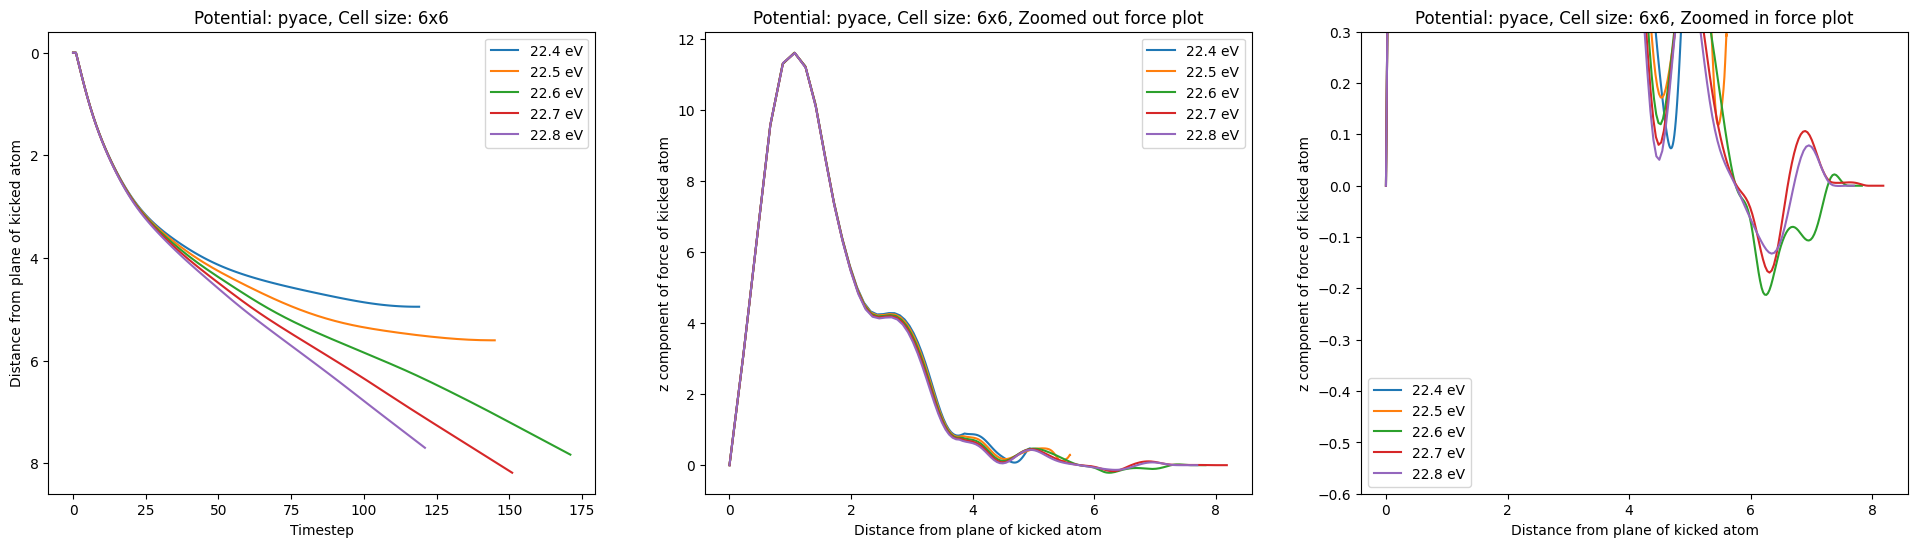

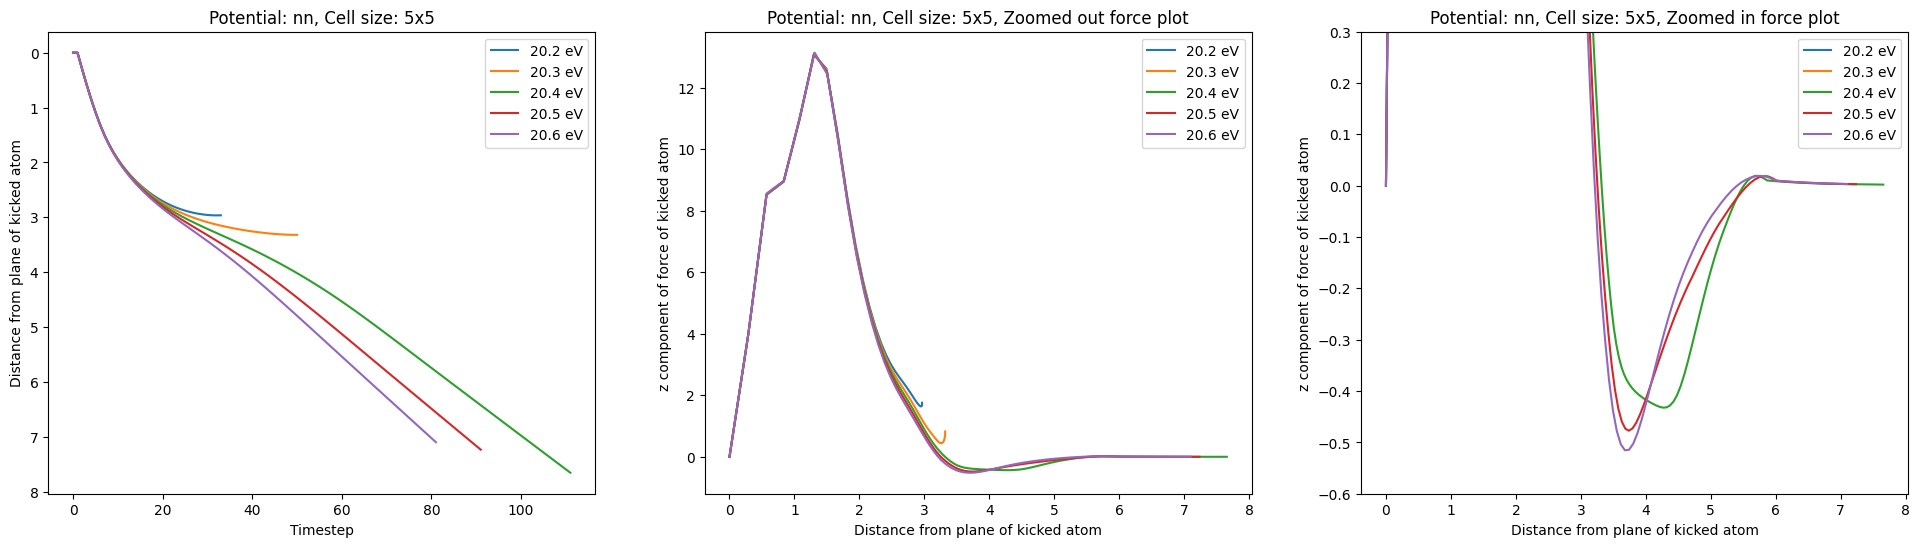

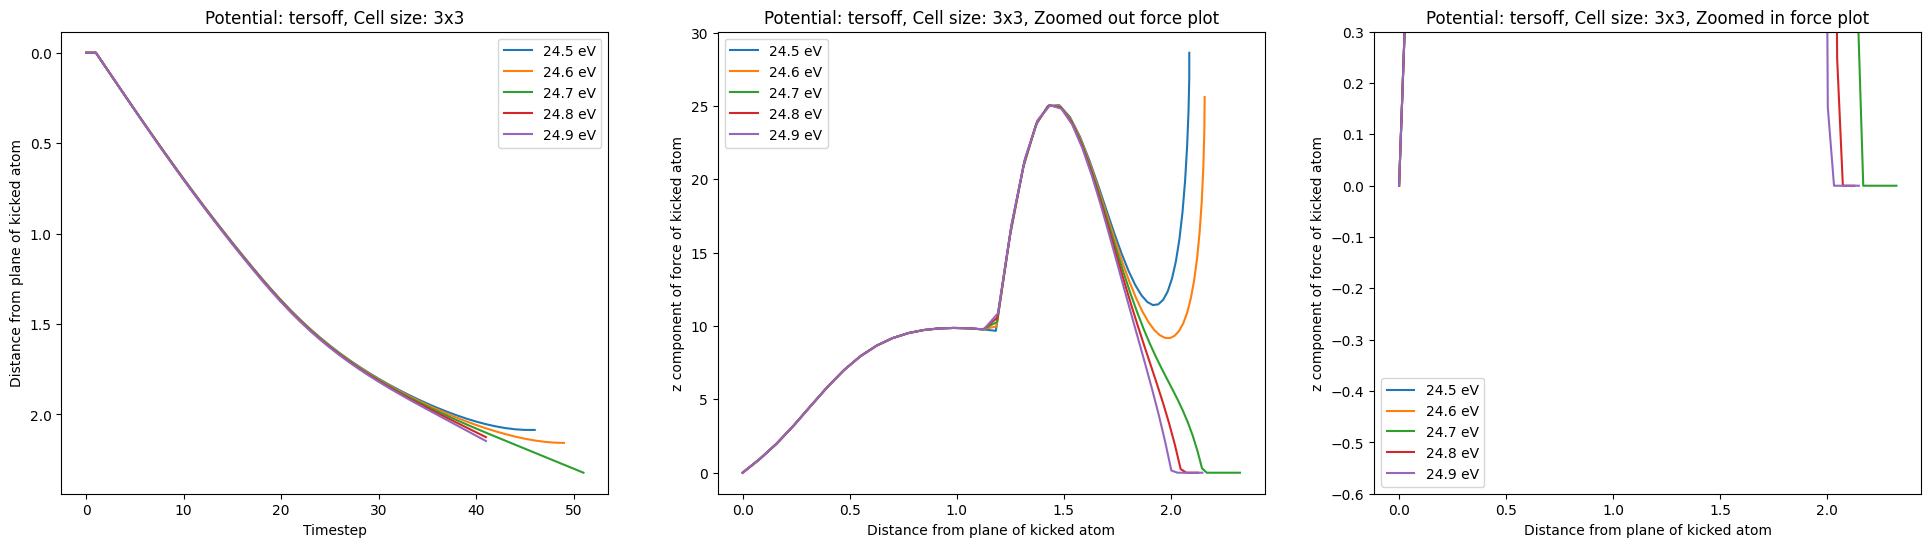

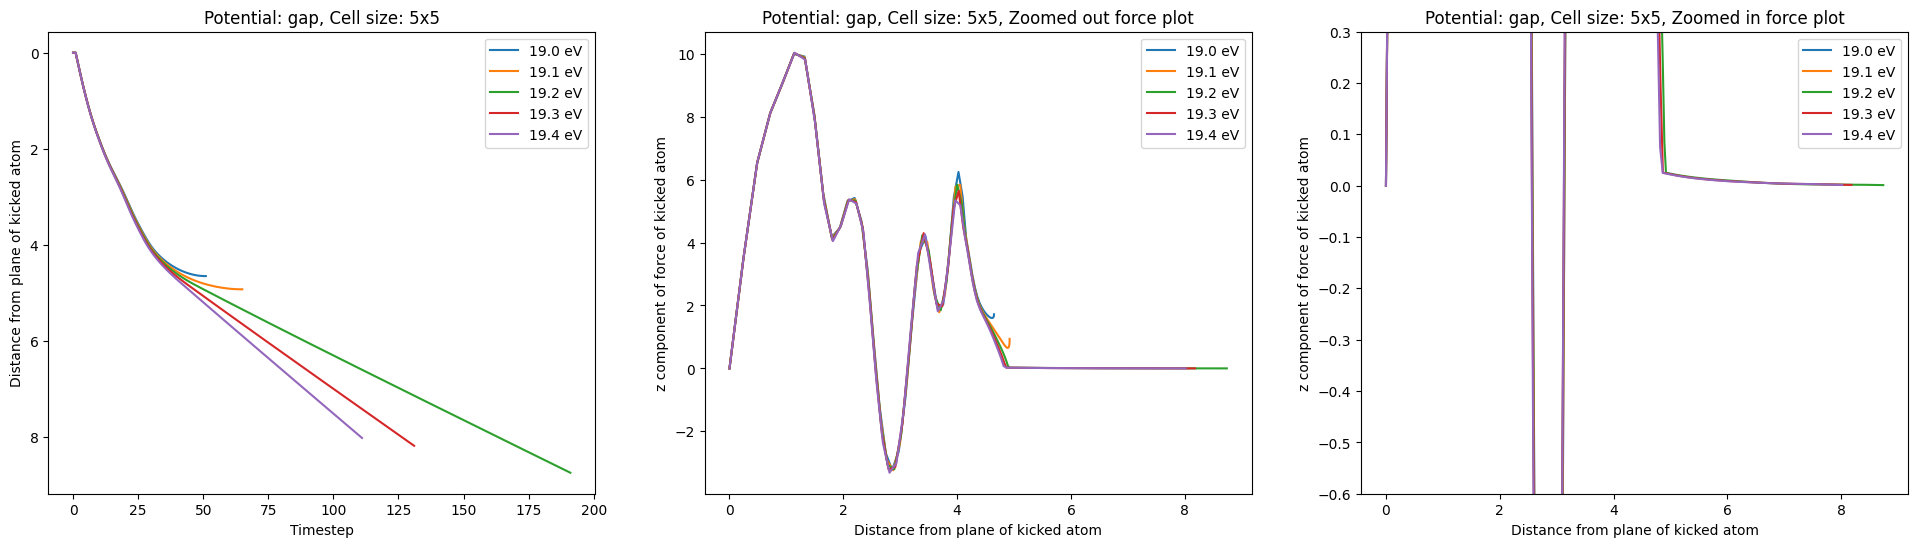

In [62]:
# Dictionary for plots. The keys are the potential names for which to look in the file system under trajectories_final_1/
# and the values are the energy ranges to look for.
potentials = {"pyace": np.arange(22.4, 22.8, 0.1), "nn": np.arange(20.2, 20.6, 0.1), "tersoff": np.arange(24.5, 25.0, 0.1), "gap": np.arange(19, 19.5, 0.1)}

for i, item in enumerate(potentials.items()):
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    potential, energies = item

    positions = []
    forces = []
    for ekin in energies:
        traj = Trajectory(f"trajectories_final_1/{potential}_{ekin:0.1f}.traj") # Load trajectory for potential and kinetic energy

        middle = get_middle(traj[-1]) # Determine middle atom to know which atom to plot for
        cell_size = int(np.sqrt(len(traj[-1])/2)) # For plot title

        position = []
        force = []
        for j in range(len(traj)):
            position.append(traj[j][middle].position[2])
            force.append(traj[j].get_forces()[middle][2])
        positions.append(position)
        forces.append(force)

    ax[0].set_xlabel("Timestep")
    ax[0].set_ylabel("Distance from plane of kicked atom")
    ax[0].set_title(f"Potential: {potential}, Cell size: {cell_size}x{cell_size}")

    ax[1].set_xlabel("Distance from plane of kicked atom")
    ax[1].set_ylabel("z component of force of kicked atom")
    ax[1].set_title(f"Potential: {potential}, Cell size: {cell_size}x{cell_size}, Zoomed out force plot")

    ax[2].set_xlabel("Distance from plane of kicked atom")
    ax[2].set_ylabel("z component of force of kicked atom")
    ax[2].set_title(f"Potential: {potential}, Cell size: {cell_size}x{cell_size}, Zoomed in force plot")
    
    for j, position in enumerate(positions):
        ax[0].plot(np.abs(np.array(position)-10), label=f"{energies[j]:0.1f} eV") # Plot distance from plane vs. timestep in left plot
    
    for j in range(len(forces)):
        ax[2].plot(np.abs(np.array(positions[j])-10), forces[j], label=f"{energies[j]:0.1f} eV") # Plot force on kicked atom vs. distance from plane in right plot
        ax[1].plot(np.abs(np.array(positions[j])-10), forces[j], label=f"{energies[j]:0.1f} eV") # Plot force on kicked atom vs. distance from plane in middle plot (zoomed out)

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    ax[0].invert_yaxis()
    ax[2].set_ylim(-0.6, 0.3)

    plt.show()

As one can see from the left-hand side plots above, which show the distance of the kicked atom from the plane, we observe clear ejections for energies larger than the previously determined $E_{KO}$. On the other hand, we can see the atoms starting to return for energies below the threshold. In the latter cases, the simulation automatically stopped due to the criterion discussed above.

The plots on the right-hand side show the out-of-plane component of the force acting on the kicked atom as a function of distance from the plane. We can make different observations for the four potentials:
- **pyace**: Here, we see that the force does not suddenly drop to zero but rather that it decays smoothly. Also, it is interesting to note that this decay does not seem to start at a fixed distance from the plane as is the case for the other potentials. It also has to be noted that, at a distance of 6 Å, the force suddenly becomes negative, indicating a push of the ejected atom away from the lattice, which is not physical.
- **nn**: With this potential, we observe a rather sharp drop of the force to a small value which then quickly approaches zero. This initial drop happens at a distance of 6 Å from the plane, indicating a fixed cut-off distance in the potential. Here, we also see a negative force, just like for pyace, but this time already at 4 Å away from the lattice and with a much greater magnitude.
- **tersoff**: In this case, the sharp drop to zero is most noticeable. Although not exactly at the same distance for each trajectory, at about 2 Å from the plane, the force suddenly drops to zero with no smooth decay whatsoever. For this potential, we do not observe a negative force at any point, which makes it stand out from the others who all show this behaviour.
- **GAP**: For this potential, the same behaviour as in the case of the nn potential albeit at a distance of 5 Å from the plane can be observed: A sudden drop of the force to a small value followed by a smooth but quick decay to zero. We again see a negative force at 2.5 Å already, which is very unphysical, as it is at a very small distance from the plane and has by far the highest magnitude of all the potentials. Also, this happens at the same distance for all energies we simulated.

All of the potentials except for tersoff exhibit a drop of the force to a negative value, which is not physical. Below, a plot of a DFT simulation done at 22.2 eV is shown, which exhibits the expected behaviour of the position and the force for such a simulation. It has to be noted that, in the original simulation, the kick was done in the other direction than in our simulations. We adjust this for better comparability to our results.

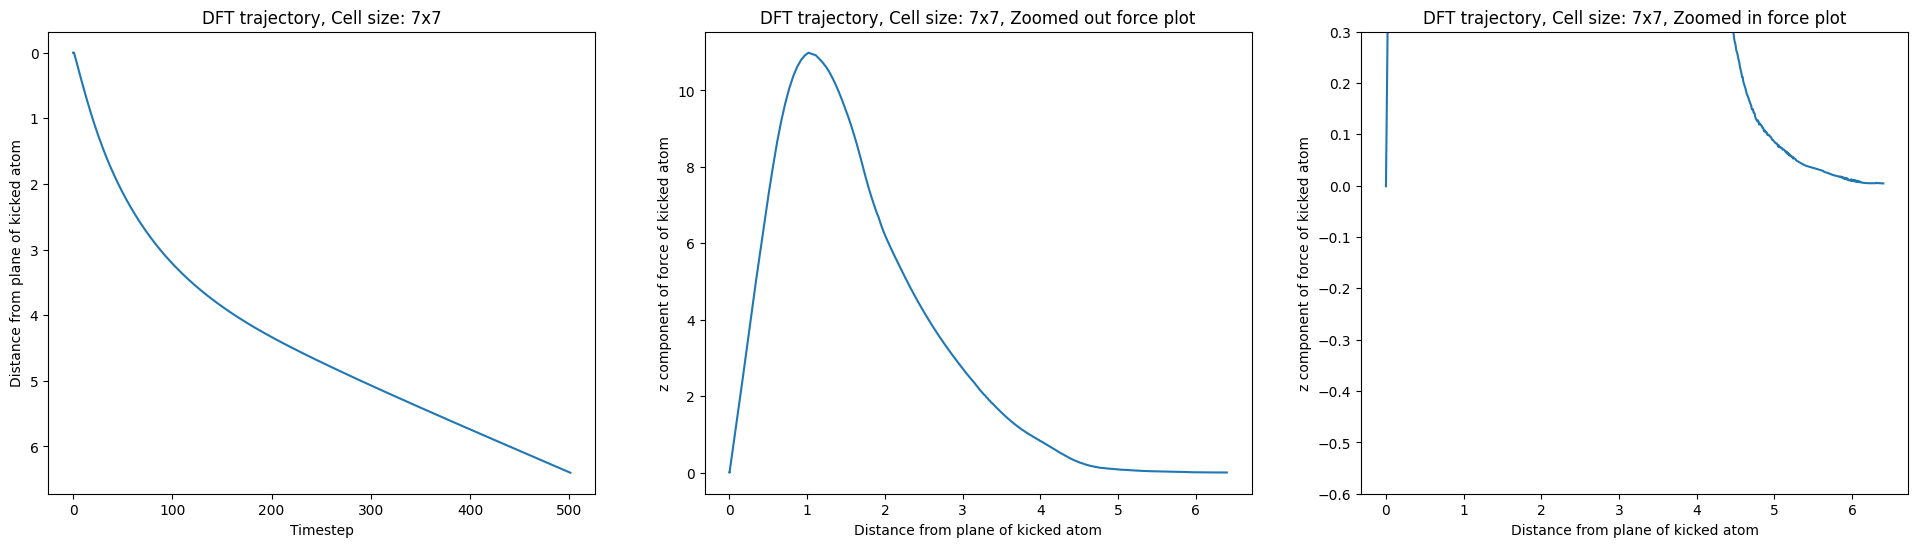

In [76]:
traj = Trajectory("gra77_PWrlx_k331_PW500_at49_E22.4.traj") # Load the DFT trajectory for 22.2 eV simulation by Toma

fig, ax = plt.subplots(1, 3, figsize=(24, 6))

positions = []
forces = []

middle = 49 # The kicked atom in this trajectory has the index 49

cell_size = int(np.sqrt(len(traj[-1])/2)) # For plot title

position = []
force = []
for j in range(len(traj)):
    position.append(traj[j][middle].position[2])
    force.append(traj[j].get_forces()[middle][2])
positions.append(position)
forces.append(force)

ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Distance from plane of kicked atom")
ax[0].set_title(f"DFT trajectory, Cell size: {cell_size}x{cell_size}")

ax[1].set_xlabel("Distance from plane of kicked atom")
ax[1].set_ylabel("z component of force of kicked atom")
ax[1].set_title(f"DFT trajectory, Cell size: {cell_size}x{cell_size}, Zoomed out force plot")

ax[2].set_xlabel("Distance from plane of kicked atom")
ax[2].set_ylabel("z component of force of kicked atom")
ax[2].set_title(f"DFT trajectory, Cell size: {cell_size}x{cell_size}, Zoomed in force plot")

for j, position in enumerate(positions):
    ax[0].plot(np.abs(np.array(position)-7.5)) # Plot distance from plane vs. timestep in left plot

for j in range(len(forces)):
    ax[2].plot(np.abs(np.array(positions[j])-7.5), -np.array(forces[j])) # Plot force on kicked atom vs. distance from plane in right plot
    ax[1].plot(np.abs(np.array(positions[j])-7.5), -np.array(forces[j])) # Plot force on kicked atom vs. distance from plane in middle plot (zoomed out)

ax[0].invert_yaxis()
ax[2].set_ylim(-0.6, 0.3)

plt.show()

To conclude the static-lattice simulations, we store the obtained values for the timesteps and the cell sizes in dictionaries for later use.

In [6]:
TIMESTEPS = {tersoff: 0.4, pyace: 1.2, nn: 1.6, gap: 1.4}
SIZES = {tersoff: (3, 3, 1), pyace: (6, 6, 1), nn: (5, 5, 1), gap: (5, 5, 1)}

## Simulations for a thermalized system

In this section, we investigate the effects of a thermalized system, i.e., lattice atoms that are undergoing thermal vibrations corresponding to different temperatures. As discussed in the theoretical background, we now expect the ejection procedure to be a stochastic process. Therefore, we will need to perform many simulations for each potential and at different temperatures in order to obtain probability distributions.

The static-lattice simulations have shown that the GAP potential has a simulation time per timestep that is orders of magnitude higher than those of the other potentials. Since, for a thermalized system, we will need to perform a very large number of simulations that already take a long time even for the faster potentials, it is not possible for us to continue investigating the GAP potential. We will therefore restrict our analysis on the three remaining potentials.

In order to being able to perform ejection simulations on a thermalized system, we first need to produce such a system and equilibrate it. A factor that has not been taken into account before is internal stress: Although we prepare the systems in the `get_atoms()` function with the equilibrium lattice constant for graphene, the different interatomic potentials result in the system being prepared with internal stresses. In order to get rid of those, we need to re-scale the cell with a certain factor, which, in the following, will be referred to as the scaling factor.

Determining the scaling factors for the different potentials is relatively simple. Thermodynamically speaking, our goal is to equilibrate the system with respect to its volume, i.e., we want to minimize the equation of state
$$-p = \left( \frac{\partial U}{\partial V} \right)_{S, \, N}$$
where $U$ is the energy, $V$ is the volume, $p$ is the pressure (in our case: stress), $S$ is the entropy and $N$ the number of particles. The subscripted variables will be held constant.

The function `determine_scaling_factors()` implements the procedure of first generating a system that is not in equilibrium through the `get_atoms()` function, re-scaling it with a range of scaling factors and then finding the scaling factor for which the total potential energy is minimal. This is equivalent to setting the pressure (stress) to zero and finding the corresponding system volume. This is done for all the potentials given to the function. We immediately run the function for the three potentials that we will be performing simulations on and store the scaling factors in a dictionary.

In [7]:
def determine_scaling_factors(calcs : list) -> dict:
    """
    Determine the factors to scale cells with by relaxing internal pressure by minimizing
    the potential energy wrt. cell volume.

    Parameters:
    -----------
    calcs : list
        List of calculators to use for determining the potential energies

    Returns:
    --------
    scaling_factors : dict
        Dictionary where the keys are the calculators and the values are the corresponding scaling factors

    """
    factors = np.arange(0.8,1.2,0.001)
    atoms = get_atoms(size=(6, 6, 1))
    scaling_factors = {}

    for calc in calcs:
        energies = np.zeros(factors.size)

        for i, factor in enumerate(factors):
            atoms2 = atoms.copy()
            atoms2.set_cell(atoms.cell*factor, scale_atoms=True)
            atoms2.calc = calc
            energies[i] = atoms2.get_potential_energy()

        scaling_factors[calc] = factors[np.argmin(energies)]
    
    return scaling_factors

scaling_factors = determine_scaling_factors([tersoff, pyace, nn])

With the static system now being in equilibrium, we can start thermalizing and equilibrating it. The following function `generate_equilibrated_system()` does exactly that and supports thermalization and quilibration in two different ensembles: The NVE ensemble and the NVT ensemble.

Thermalization in the NVE ensemble is achieved by assigning each atom in the static lattice a random momentum drawn from a Maxwell Boltzmann (MB) distribution. The temperature we use for the MB distribution is double the temperature we want our system to have after equilibration, since, due to the equipartition theorem, the initial average kinetic energy of $\langle E_{kin}^{init} \rangle = k_B \, 2 T$ will, in equilibrium, be equally partitioned on the kinetic and potential energy, i.e., $\langle E_{kin}^{eq} \rangle = \langle E_{pot}^{eq} \rangle  = k_B \, T$.

On the other hand, the approach for thermalizing in the NVT ensemble is to use Langevin dynamics, which implements a thermostat that couples the system to a heat bath. After equilibration, the system will have the desired temperature, at which point we can switch to an NVE ensemble and equilibrate for a couple more time steps.

In addition to the `generate_equilibrated_system()` function, we also implement a function `plot_temperature()` that takes a simulation trajectory and plots the system's temperature as a function of time. We use this function later to determine whether the systems we prepared actually equilibrated to the correct temperatures.

In [8]:
def generate_equilibrated_system(size : tuple, T : float, n_equilibration : int, timestep : float, calc : calculator, scaling_factors : dict, out_trajectory=False, NVT=False, filename=None) -> (Atoms, Trajectory):
    """
    Function that generates a graphene lattice, gives each atom a velocity drawn from a MB distribution
    and equilibrates the system

    Parameters
    ----------
    size : tuple
        The size of the graphene lattice in units of unit cells

    T : float
        The temperature in Kelvin used for the MB distribution

    n_equilibration : int
        Number of equilibration  timesteps to perform

    timestep : float
        Timestep to use for equilibration in fs

    calc : ase.calculators.calculator
        Calculator to use for equilibration

    scaling_factors : dict
        Dictionary with scaling factors for cell that contains the calculator used as a key

    out_trajectory : bool
        Whether or not to return the equilibration trajectory

    NVT : bool
        Equilibrate in NVT rather than in NVE ensemble

    filename : str
        Name of the trajectory file to write to. If none, use temporary file and return trajectory instead

    Returns
    -------
    gra : Atoms
        The equilibrated graphene lattice

    traj : Trajectory
        The equilibration trajectory, only returned if out_trajectory is True and no filename is given
    """
    gra = get_atoms(size)
    gra.set_cell(gra.cell*scaling_factors[calc], scale_atoms=True)
    gra.calc = calc

    if not NVT:
        MaxwellBoltzmannDistribution(gra, temperature_K=2*T) # Thermalize atoms. Use 2*T to get desired kinetic energies due to equipartition theorem
        Stationary(gra) # Move into center of mass reference frame
        
    if filename == None:
        filename = f"/tmp/traj_equil_{time.time()}.traj"
    traj = Trajectory(filename, "w", gra) if out_trajectory else None

    if NVT:
        Langevin(gra, timestep=timestep*units.fs, trajectory=traj, temperature_K=T, friction=0.01/units.fs).run(n_equilibration) # Equilibrate system in NVT ensemble
    else:
        VelocityVerlet(gra, timestep=timestep*units.fs, trajectory=traj).run(n_equilibration) # Equilibrate system in NVE ensemble

    if not traj == None:
        traj.close()

    if out_trajectory and filename.startswith("/tmp"):
        return gra, Trajectory(filename)
    return gra

def plot_temperature(traj : Trajectory, const=None) -> None:
    """
    Plot the temperature of a trajectory

    Parameters
    ----------
    traj : Trajectory
        The trajectory to plot the temperature from

    const : float
        Temperature to draw hline at
    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    temp = np.zeros(len(traj))
    for i in range(len(traj)):
        temp[i] = traj[i].get_temperature()
    
    if const != None:
        ax.hlines(const, 0, len(traj), ls="--", color="gray", label=f"T={const} K")
    ax.plot(temp, label="Simulation temperature")

    if const != None:
        ax.legend()

    ax.set_xlabel("Timestep")
    ax.set_ylabel("Temperature [K]")
    plt.show()

The next function we implement (`propagate_system()`) is for propagating a thermalized system in the NVE ensemble for a given number of time steps and writing the trajectory to a file.

In [9]:
def propagate_system(atoms : Atoms, n_timestep : int, timestep : float, filename=None) -> None:
    """
    Propagate a system of atoms using Velocity Verlet

    Parameters
    ----------
    atoms : Atoms
        System to propagate
    
    n_timestep : int
        Number of timesteps to propagate for

    timestep : float
        Timestep in fs

    filename : str
        If not None, save the trajectory to a file
    """ 

    traj = Trajectory(filename, "w", atoms) if filename != None else None

    VelocityVerlet(atoms, timestep=timestep*units.fs, trajectory=traj).run(n_timestep) # Propagate system in NVE ensemble

    if not traj == None:
        traj.close()
    

The idea for the simulations that we will do is that we first generate and equilibrate systems in different potentials and at different temperatures and subsequently propagate them for a large number of timesteps. This way, we will end up with very long trajectories that we can use for ejection simulations. Then, we use multiple frames of each trajectory to perform ejection simulations and determine the threshold energy, resulting in a large sample of threshold energies for each trajectory, i.e., for each temperature and potential.

In order to avoid correlations between the sampled threshold energies in a trajectory, we need to carefully choose the number of timesteps to wait between the frames that we use for ejection simulations. For this, we can use the time autocorrelation function of the momentum of the kicked atom, which should ideally approach zero after some time, when correlations have died away. We then know how long we have to wait between simulation frames in order to have uncorrelated initial configurations.

The function `autocorrelate_momentum()` calculates the time autocorrelation function of the kicked atom's momentum using NumPys `correlate()` function.

In [10]:
def autocorrelate_momentum(traj : Trajectory) -> np.ndarray:
    """
    Compute the autocorrelation function for the z component of the momentum of the middle atom of the
    given trajectory

    Parameters
    ----------
    traj : Trajectory
        The trajectory to use

    Returns
    -------
    autocorrelation : np.ndarray
        The autocorrelation function values for the trajectory
    """

    
    middle = get_middle(traj[-1])
    M = len(traj)

    momenta = np.zeros(M)
    for i in range(M):
        momenta[i] = np.linalg.norm(traj[i][middle].momentum) # Store magnitude of the target atom's momentum

   
    momenta -= np.mean(momenta) # Remove com motion

    autocorrelation = np.correlate(momenta, momenta, mode="full")[-M:] / np.arange(M, 0, -1)
    autocorrelation /= np.std(momenta)**2 # normalization
       
    return autocorrelation

For each potential, we now generate an equilibrated thermalized system.

In [289]:
# Determining n_steps to simulate in order to avoid correlations, using large system size

autocorrelation_test_potentials = {"tersoff": tersoff, "pyace": pyace, "nn": nn}

for name, calc in autocorrelation_test_potentials.items():
    equil_test = generate_equilibrated_system(size=(6, 6, 1), T=300, n_equilibration=1000, timestep=TIMESTEPS[calc], calc=calc, scaling_factors=scaling_factors, out_trajectory=True, NVT=False, filename=f"trajectories_correlations/{name}.traj")


We then apply the `autocorrelate_momentum()` function to those systems and plot the results.

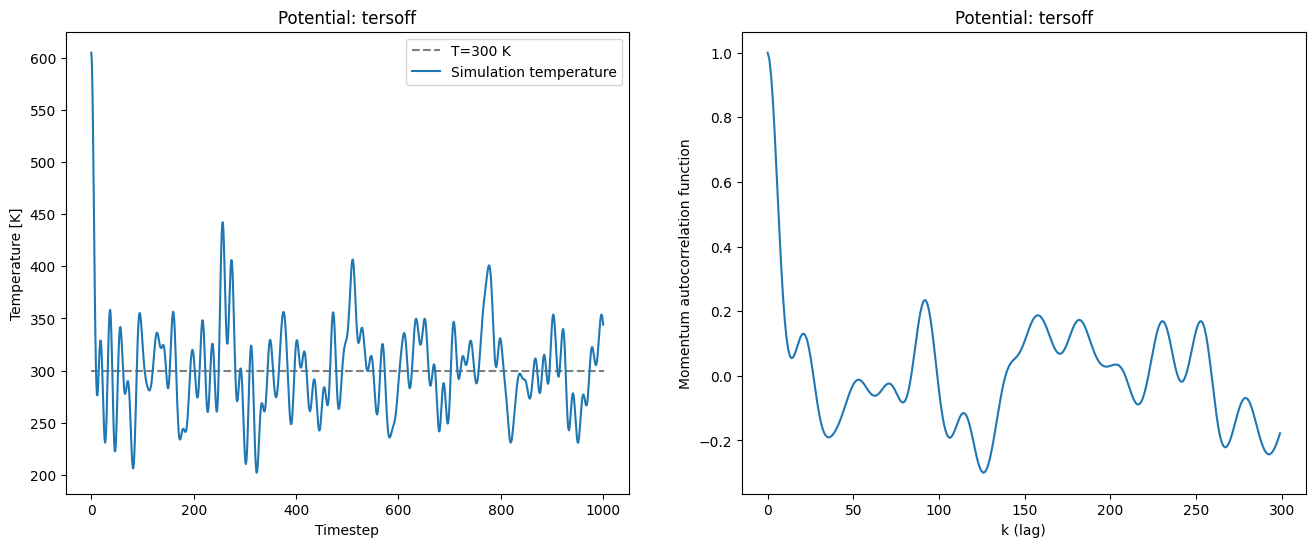

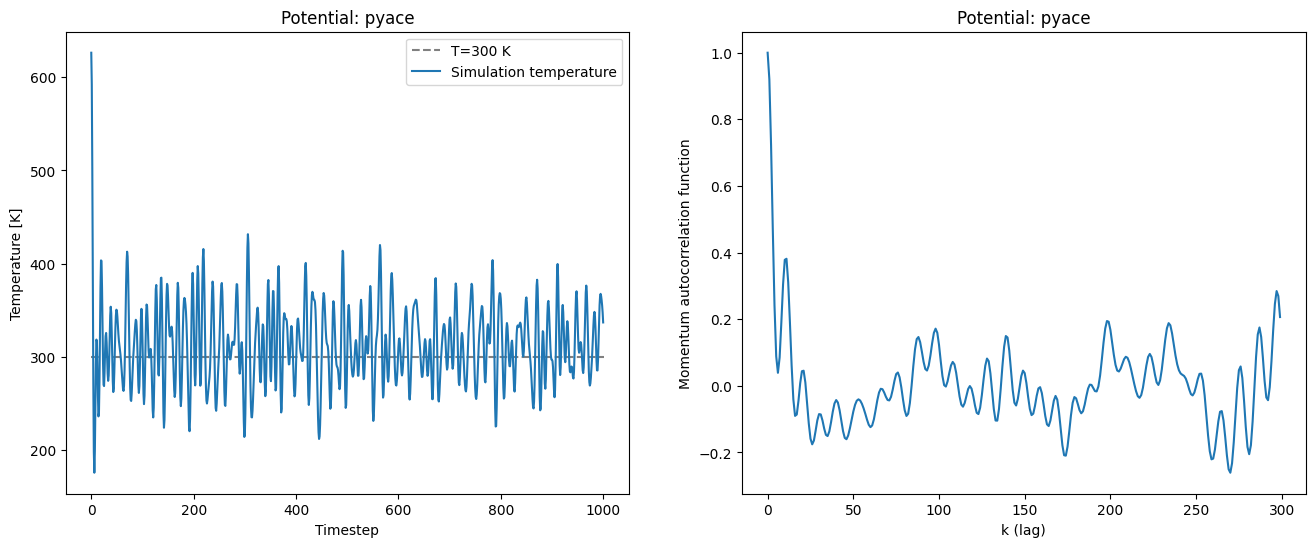

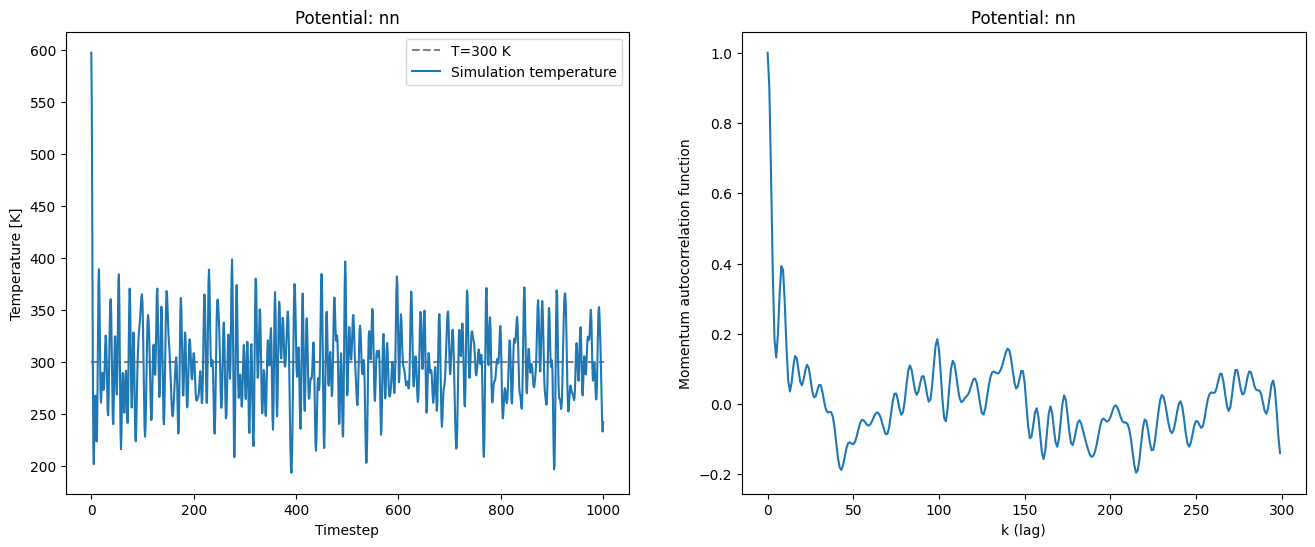

In [290]:
# Plot the results

for name, calc in autocorrelation_test_potentials.items():
    traj_equil_test = Trajectory(f"trajectories_correlations/{name}.traj")
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    temp = np.zeros(len(traj_equil_test))
    for i in range(len(traj_equil_test)):
        temp[i] = traj_equil_test[i].get_temperature()
    
    ax[0].hlines(300, 0, len(traj_equil_test), ls="--", color="gray", label="T=300 K")
    ax[0].plot(temp, label="Simulation temperature")

    ax[0].legend()

    ax[0].set_xlabel("Timestep")
    ax[0].set_ylabel("Temperature [K]")

    ax[1].plot(autocorrelate_momentum(traj_equil_test)[:300]) # Plot autocorrelation function up to k = 100 to avoid finite size effects

    ax[1].set_xlabel("k (lag)")
    ax[1].set_ylabel("Momentum autocorrelation function")

    ax[0].set_title(f"Potential: {name}")
    ax[1].set_title(f"Potential: {name}")

    plt.show()

In the left-hand side plots above, one can see the temperature curve of the propagated systems for each potential. On the right-hand side, the corresponding autocorrelation functions are plotted. Although they are by far not ideal, probably due to the small system size of 6 $\times$ 6, we can be reasonably sure that correlations have mostly died away after 100 time steps, so we will use this value in the following simulations.

With all the preparations done, we can now start to actually generate the before-mentioned long trajectories. For each potential, we will generate four trajectories, one for each temperature in {100K, 200K, 300K, 350K}. Each trajectory has a length of 10.000 time steps after equilibration (with 2.500 equilibration times steps). In order to minimize finite-size effects, we choose a system size of 6 $\times$ 6 for all potentials, which is the largest system size that still takes a reasonable time to simulate. For time steps, we use the values we previously determined through optimization.

This leaves us with a total number of 101 frames per trajectory (i.e., potential and temperature) that we can use to perform ejection simulations and subsequently produce a probability distribution for the threshold energies.

In [ ]:
# Prepare thermalized systems for analysis
temps = [100, 200, 300, 350] # Temperatures to prepare trajectories for

for temp in temps:
    for name, calc in {"tersoff": tersoff, "pyace": pyace, "nn": nn}.items():
        print(f"[{temp}K] Equilibrating potential {name}")
        equil_system = generate_equilibrated_system(size=(6, 6, 1), T=temp, n_equilibration=2500, timestep=TIMESTEPS[calc], calc=calc, scaling_factors=scaling_factors) # Generate equilibrated system
        
        filename = f"trajectories_vibrations/{name}_{temp}.traj"
        print(f"[{temp}K] Propagating potential {name}")
        propagate_system(atoms=equil_system, n_timestep=10000, timestep=TIMESTEPS[calc], filename=filename) # Propagate system and save trajectory to file


The following plot shows the temperature curve of one of those long trajectories (pyace at 300K).

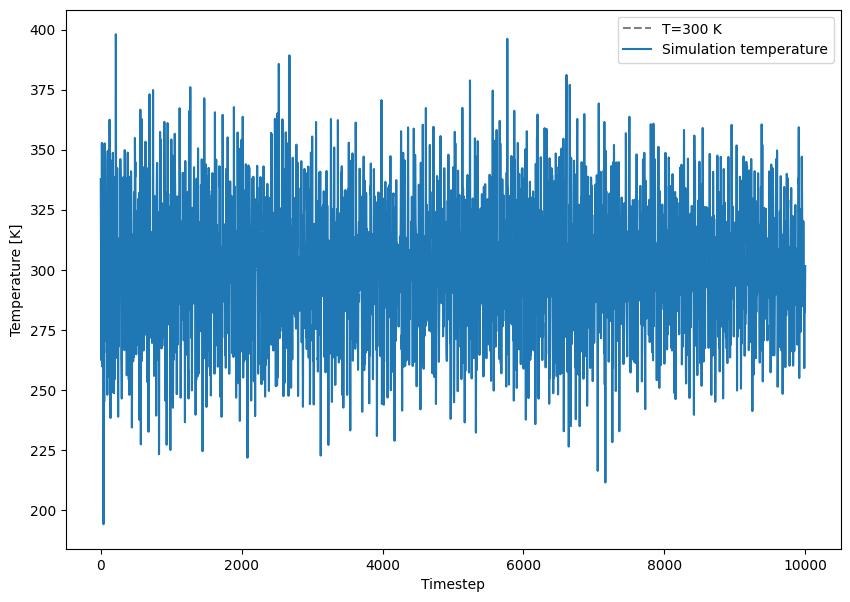

In [17]:
plot_temperature(traj=Trajectory("trajectories_vibrations/pyace_300.traj"), const=300)

The last step of simulations is to perform ejection simulations on all the trajectories we just generated. For each frame in each trajectory, we simulate until we reach the first ejection, record the energy at which this first ejection was achieved and save it in a corresponding `.csv` file for later analysis, such that we are left with one results file per trajectory containing all the recorded threshold energies.

It is important to note that we do not use the algorithm that tries to detect ejection described above, since it has proven to be too unstable for thermalized systems. So, we let every simulation run until the end, unless a reversal of momentum was detected, i.e., the atom was not ejected. This is slower but produces considerably better results.

In [ ]:
temps = [100, 200, 300, 350] # Temperatures to test
potentials = {"tersoff": tersoff, "nn": nn, "pyace": pyace} # Potentials to test
#potentials = {"nn": nn}
energies = {tersoff: np.arange(22.0, 27.5, 0.1), pyace: np.arange(20.0, 25.5, 0.1), nn: np.arange(18.0, 24.0, 0.1)}

thresholds = {} # Dict for the results (keys are potentials and temperatures and values are lists of threshold energies)

# Prepare dictionary with empty lists
for name in potentials.keys():
    for temp in temps:
        thresholds[f"{name}@{temp}"] = []

for temp in temps:
    for name, calc in potentials.items():
        traj = Trajectory(f"trajectories_vibrations/{name}_{temp}.traj") # Load the prepared trajectory
        key = f"{name}@{temp}"
        for frame in range(0, len(traj), 100):
            atoms = traj[frame] # Load the frame (we go through the whole trajectory file and always skip 100 frames due to correlations)
            for ekin in energies[calc]:

                prefix = f"[{name}@{temp}K] [{ekin:0.1f}] "
                filename = f"/tmp/trajectories_vibration_ejection.traj" # Temporary file to write trajectories to (we don't need them)

                # We simulate until one simulation ran through completely without the atom having returned (momentum having reversed) before
                # We set timesteps to 80 but are really simulating 80*3=240 timesteps, so we should be fine
                if run_simulation(atoms.copy(), calc, ekin, 80, TIMESTEPS[calc], filename, check_ejected=True, printing=False, ejection_threshold=0) != "not ejected":
                    print(prefix + f"Threshold reached (first ejection)! ({int(frame/100) + 1}/{int(len(traj)/100) + 1})")
                    thresholds[key].append(ekin) # Write threshold to thresholds dictionary
                    break

        if len(thresholds[key]) != 0:
            np.savetxt("results_vibrations/" + key + ".csv", np.array(thresholds[key]), delimiter=",")

## Analysis of the thermalized system simulations

With the simulations done, we can now start to reconstruct the sampled ejection probability distributions. For that, we first define two functions that allow us to load the `.csv` files produced in the previous simulation. `load_results()` loads only a specific sample with given potential and temperature, while `load_all_results()` returns a dictionary of all samples it could find, organized by potential and temperature.

In [11]:
def load_results(potential : str, temp : float) -> np.ndarray:
    """
    Loads a specific result for the simulation of the threshold energy of a
    thermalized system.

    Parameters
    ----------
    potential : str
        The name of the potential used in the simulation

    temp : float
        The temperature used in the simulation

    Returns
    -------
    result : np.ndarray
        The first ejection energies obtained in the simulation
    """
    path = f"results_vibrations/{potential}@{temp}.csv"
    assert os.pyth.isfile(path), f"Result {path} does not exist."
    return np.loadtxt(path, delimiter=",")

def load_all_results() -> dict:
    """
    Load all the results found in results_vibrations/ and return it as a dict

    Returns
    -------
    loaded_results : dict
        A dictionary containing all the results, like the one produced in the simulation that
        generated the .csv files

        Keys: potential@temperature
        Values: np.ndarray of the obtained threshold energies

    potentials : list
        The names of the potentials that were loaded

    temps : list
        The temperatures that were loaded
    """
    pattern = re.compile(r"^[a-zA-Z0-9\s]+@[0-9]+(?:\.[0-9]+)?\.csv$", re.IGNORECASE)
    files = [f for f in os.listdir("results_vibrations") if os.path.isfile(os.path.join("results_vibrations", f)) and pattern.match(f)]

    loaded_results = {}
    for file in files:
        loaded_results[file[:-4]] = np.loadtxt(os.path.join("results_vibrations", file), delimiter=",")

    potentials = list(set([name.split("@")[0] for name in loaded_results.keys()])) # Find all unique potential names
    temps = list(set([float(name.split("@")[1]) if "." in name.split("@")[1] else int(name.split("@")[1]) for name in loaded_results.keys()])) # Find all unique temperatures

    return loaded_results, potentials, temps

Since we want to fit a normal (gaussian) distribution to the data, we need to implement the corresponding probability density function

$$f(x) = \frac{1}{\sigma \sqrt{2\pi}} \cdot \exp{\left( - \frac{(x - \mu)^2}{2 \, \sigma^2} \right)}$$

with the mean $\mu$ and the standard deviation $\sigma$.

In [12]:
def normal(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*np.power((x - mu)/sigma, 2))

We will be fitting the normal distribution to a histogram with bins of equal width. To determine the ideal number of bins, we plot the histograms of all the trajectories with the corresponding fit for different bin counts and visually inspect the results.

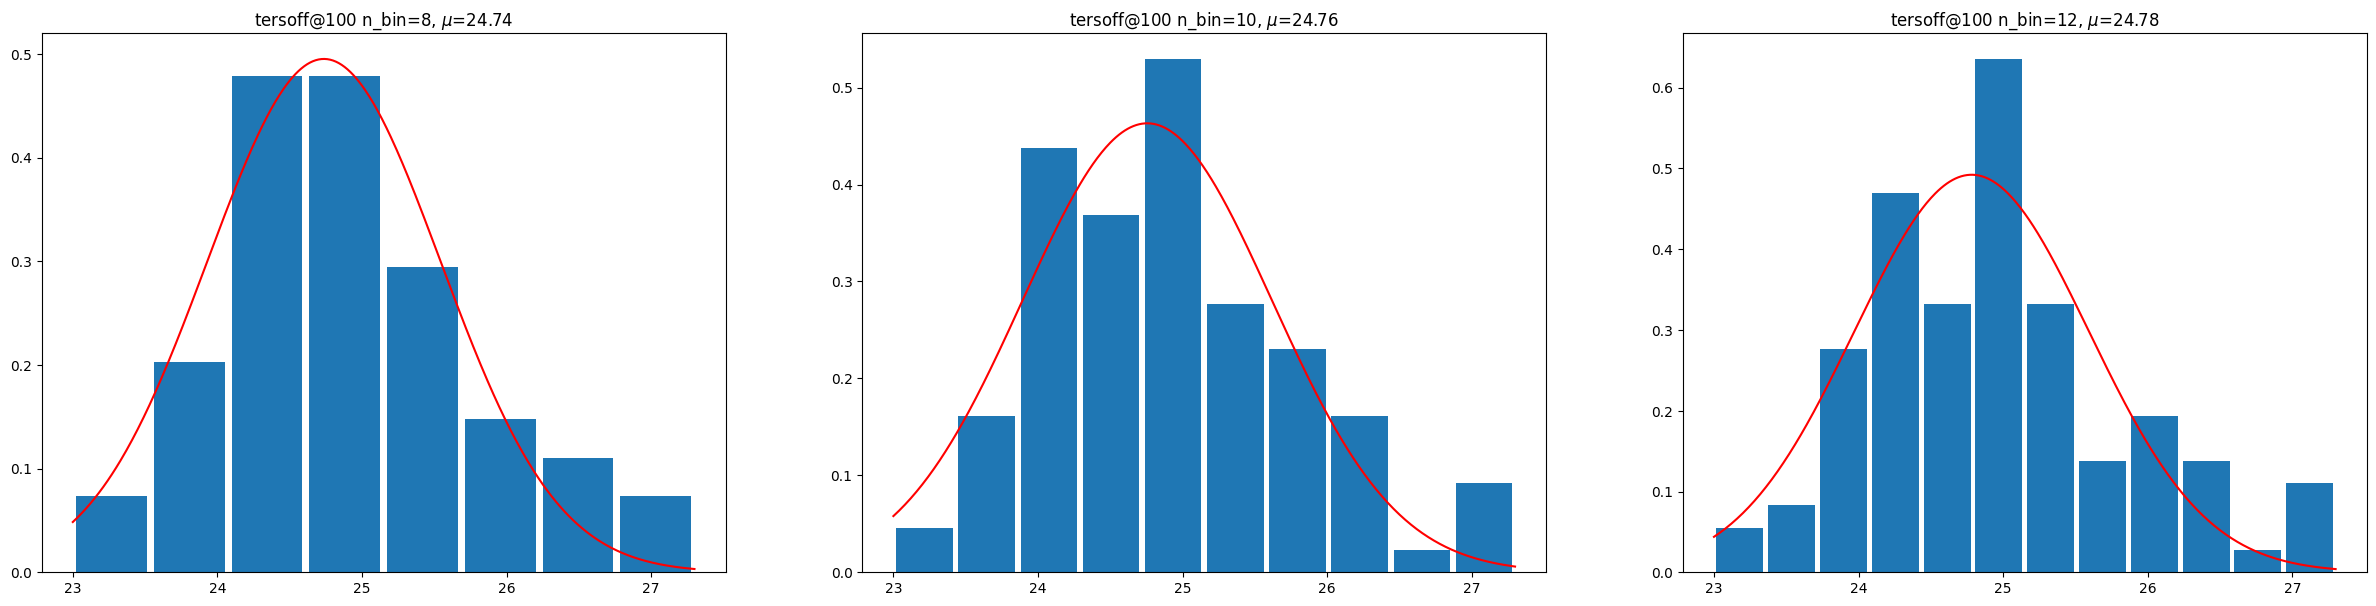

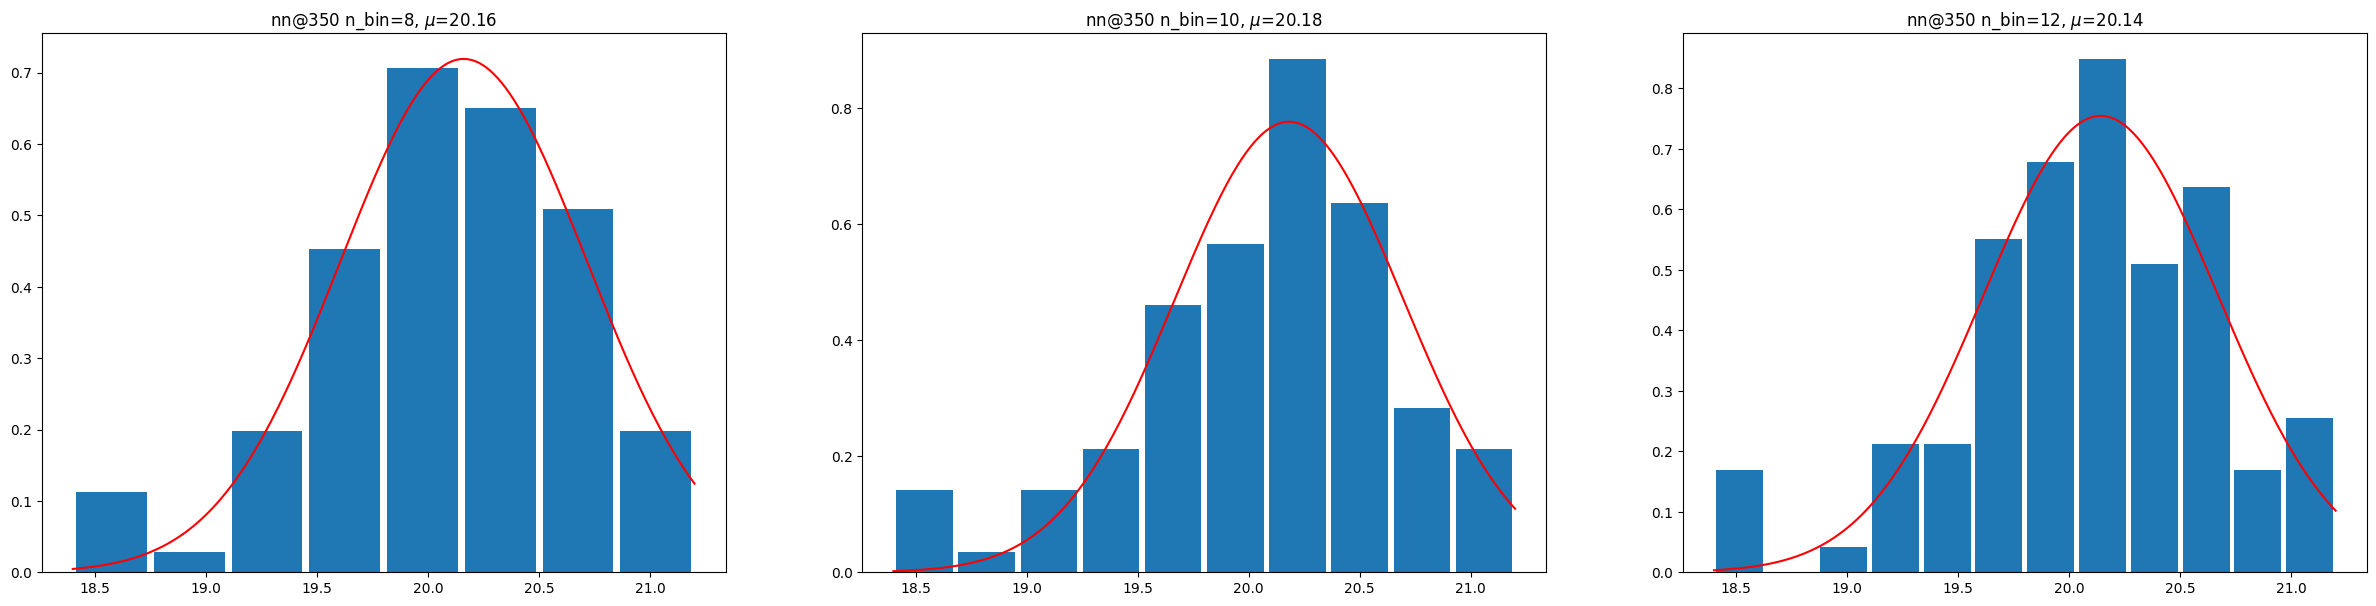

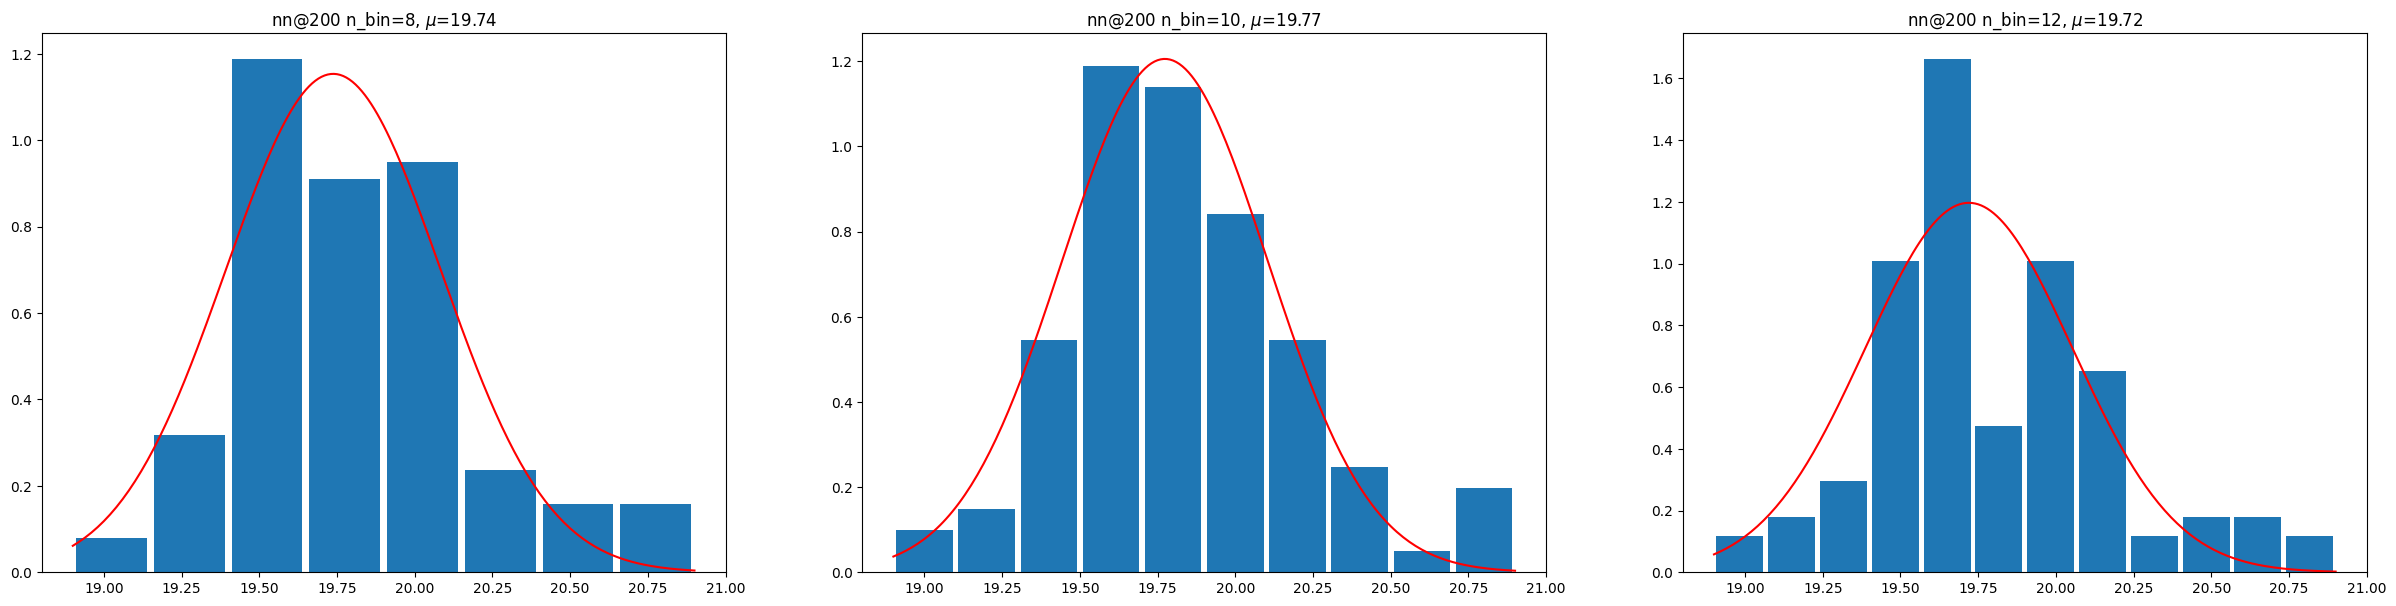

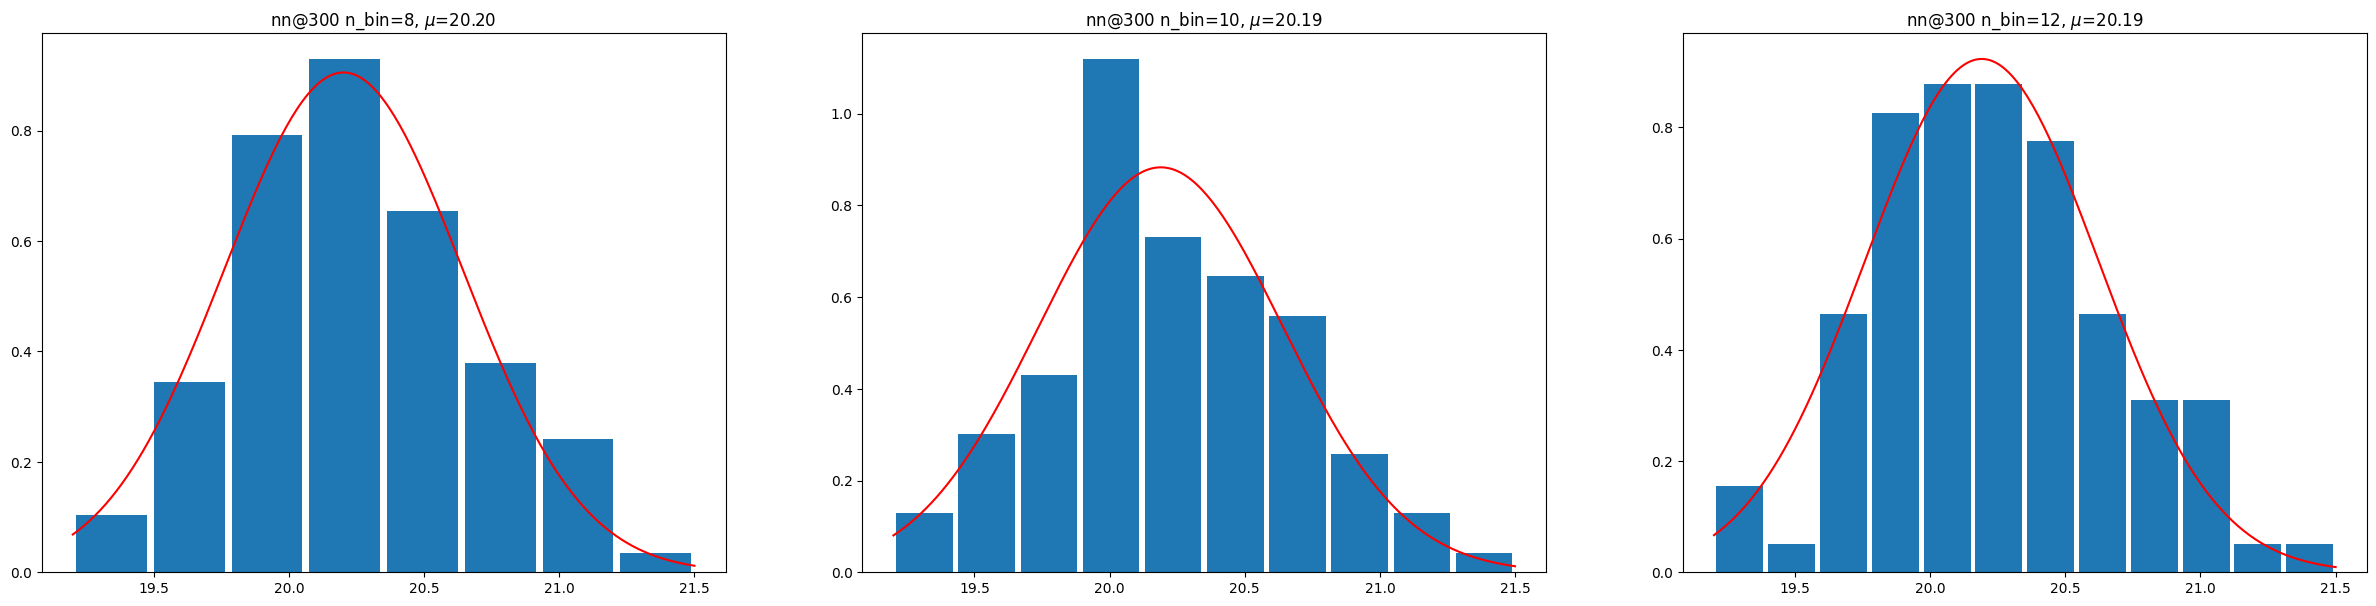

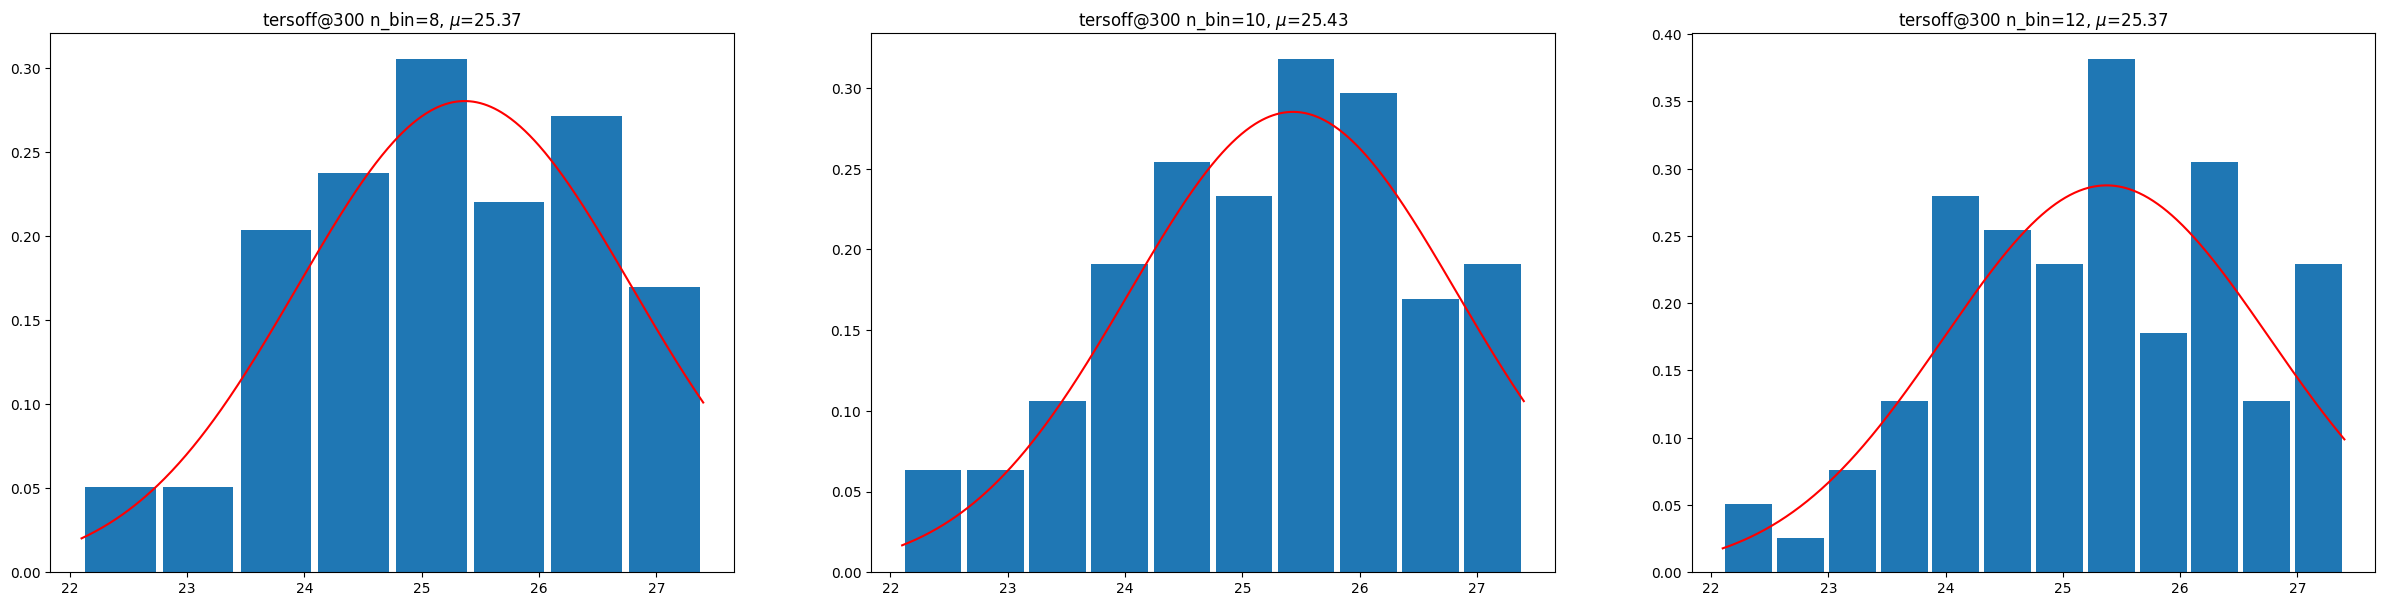

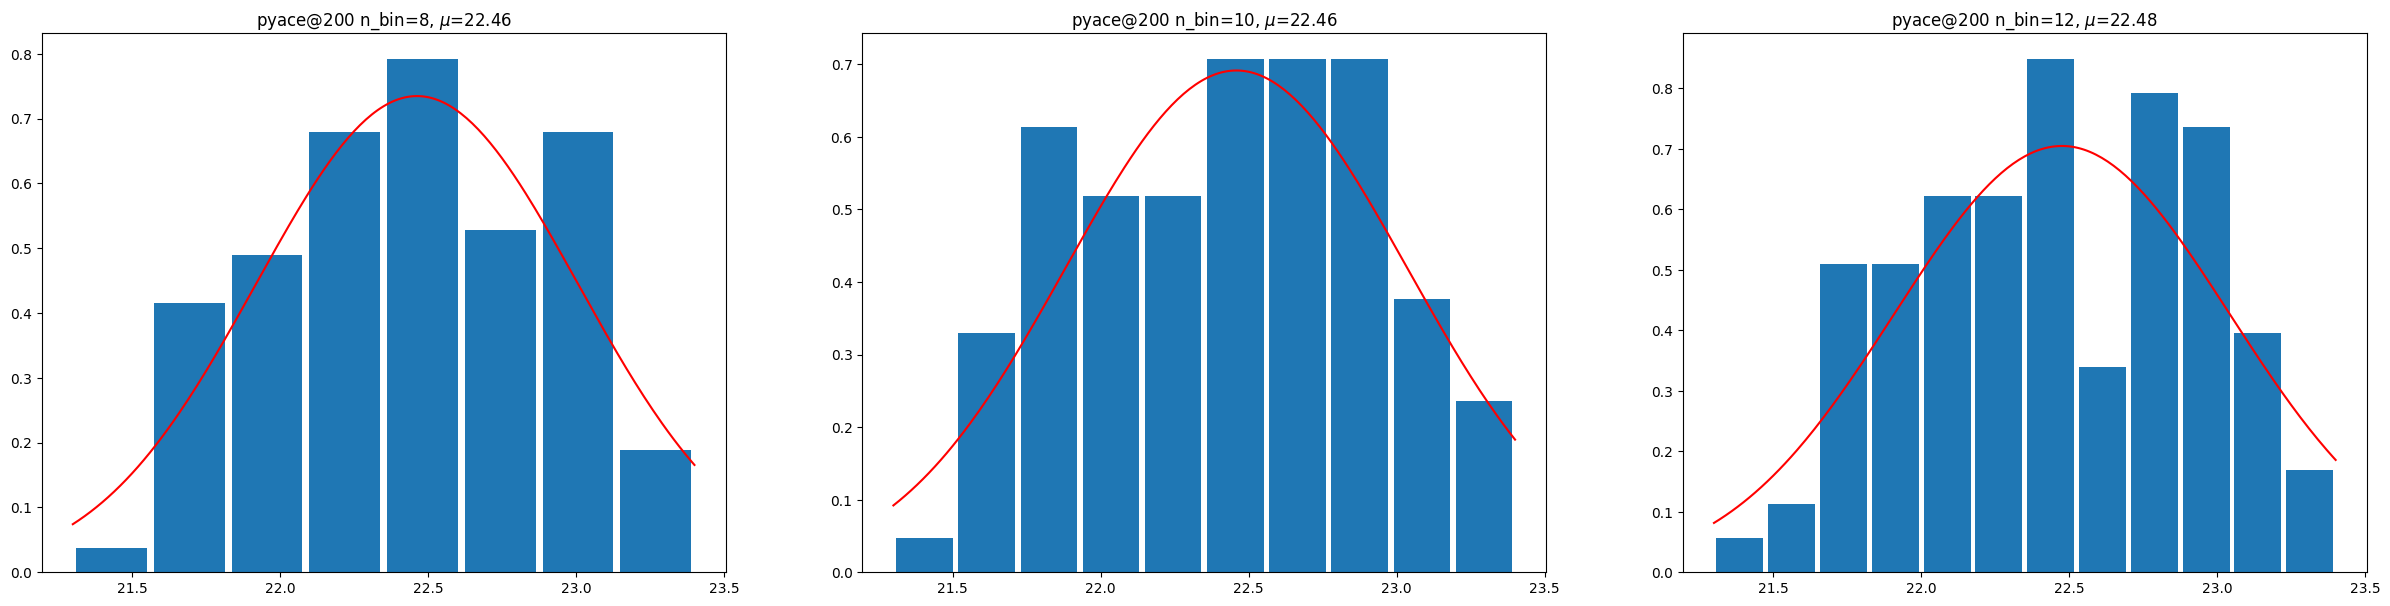

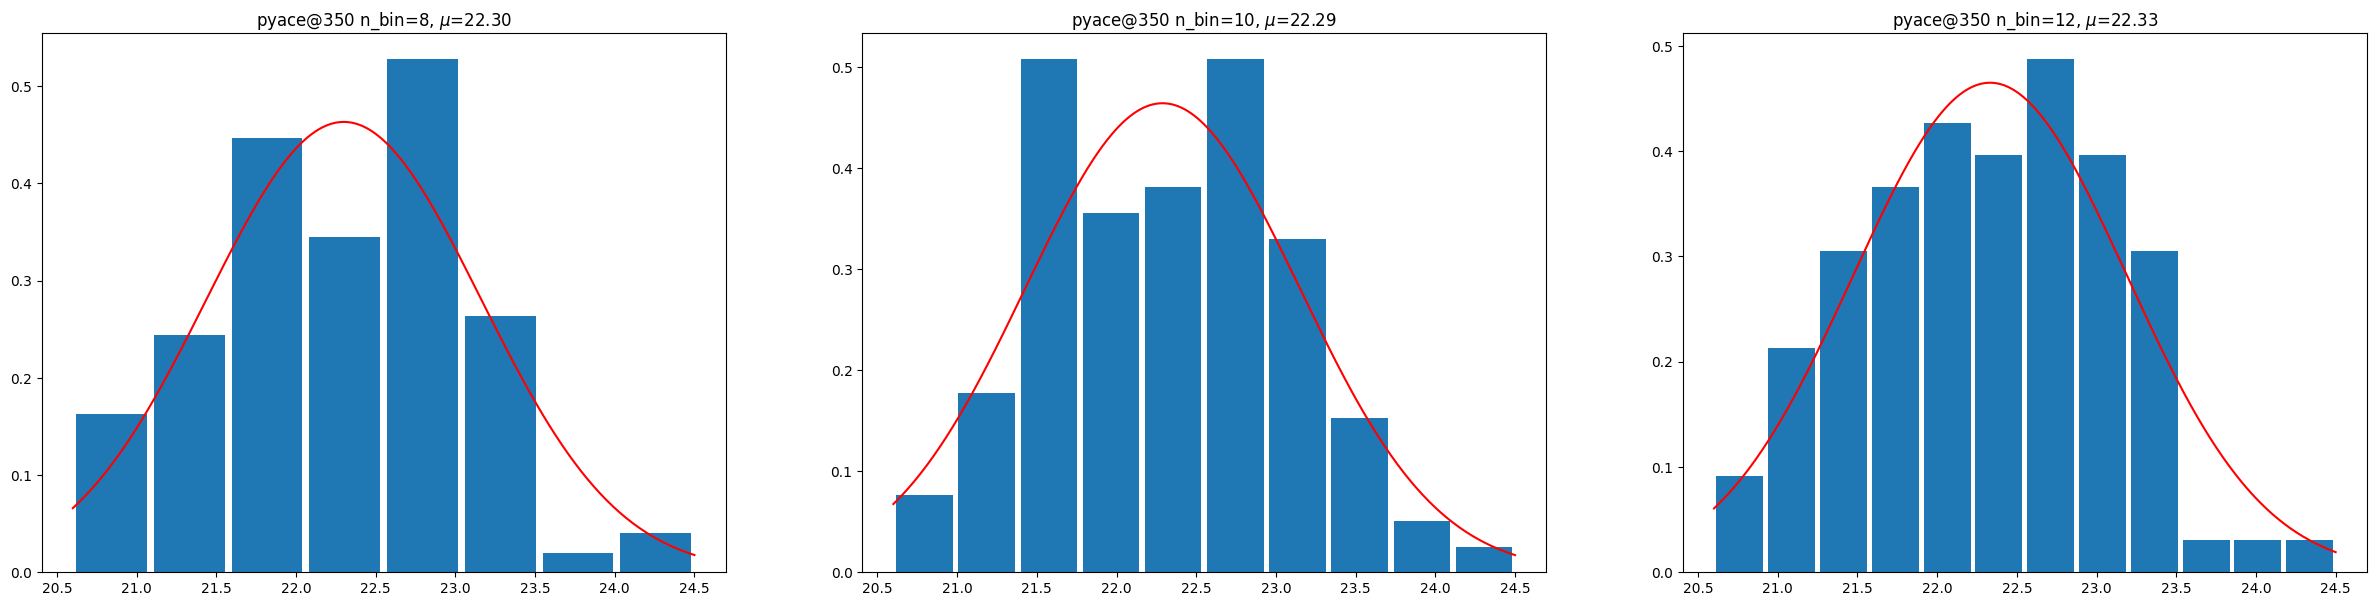

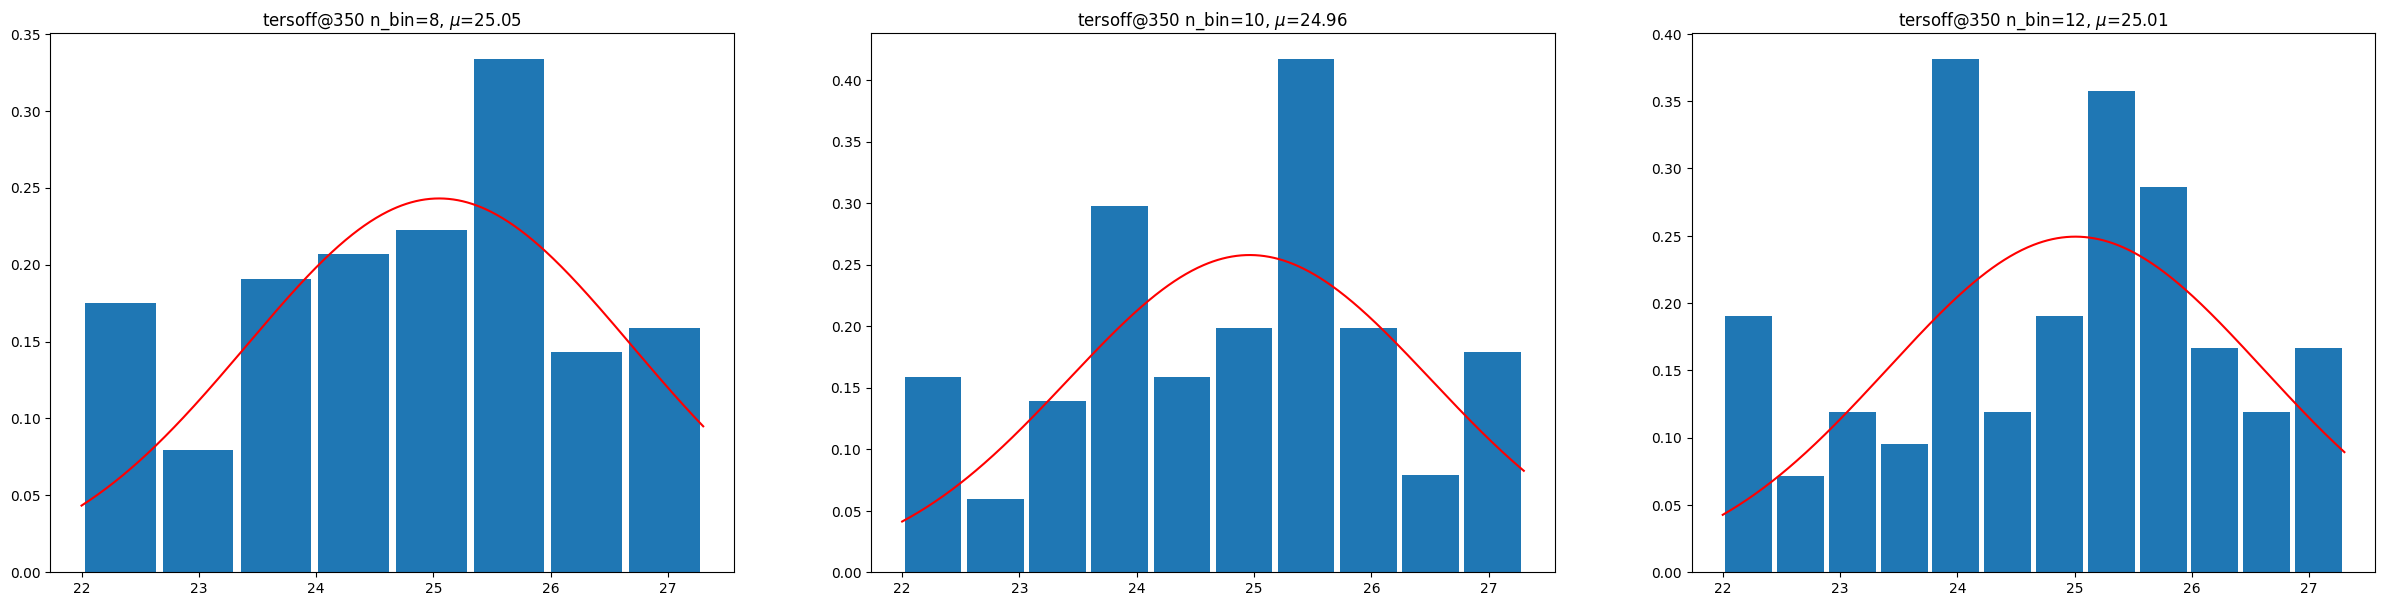

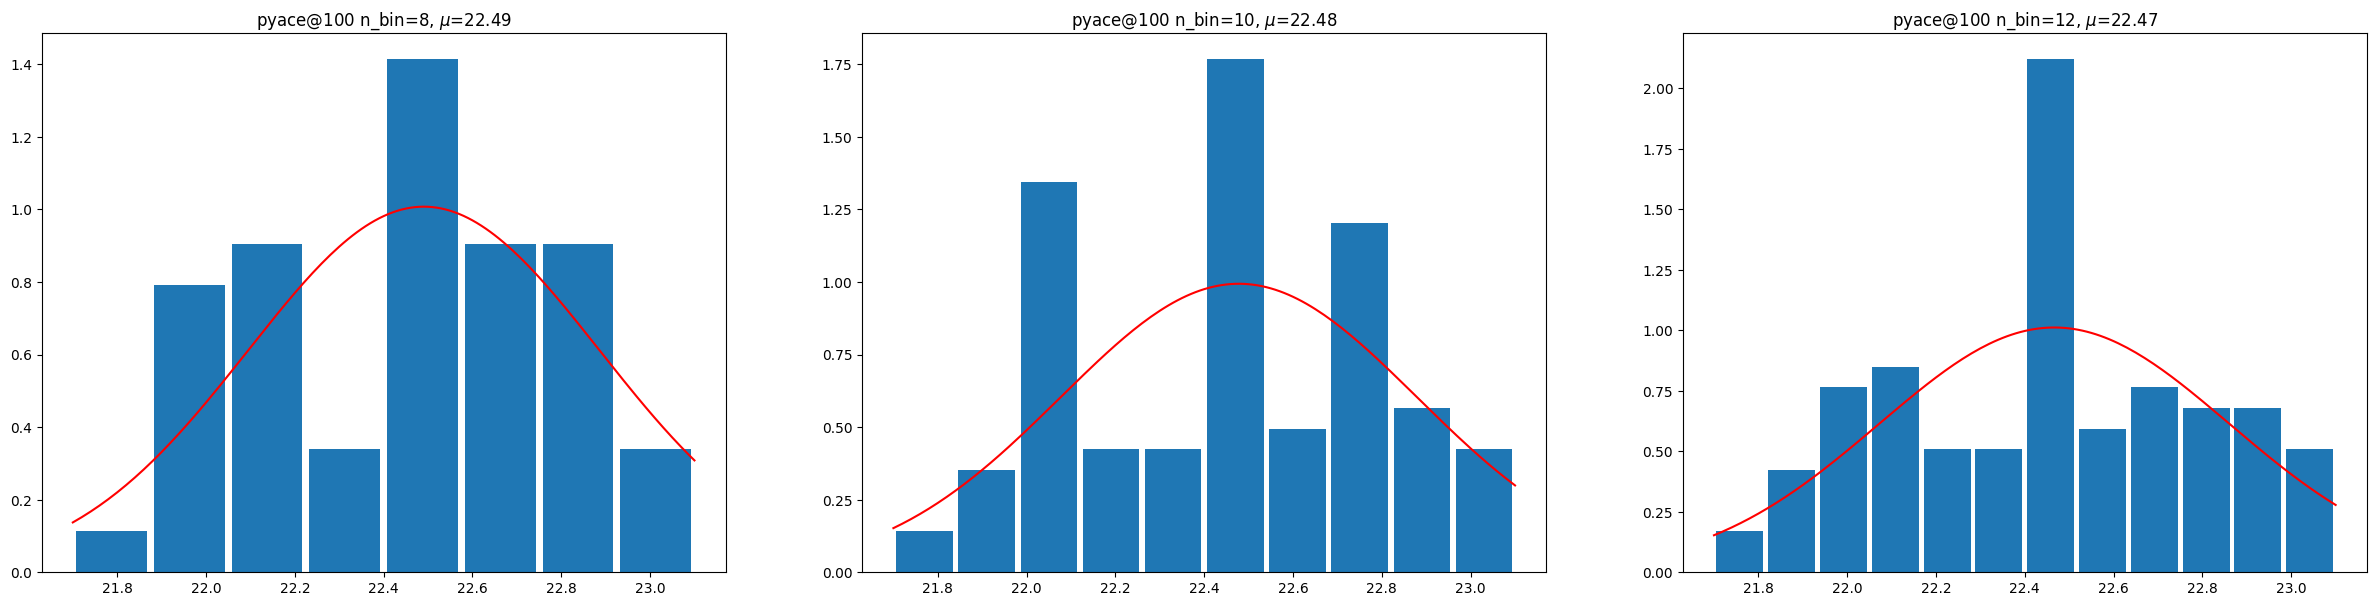

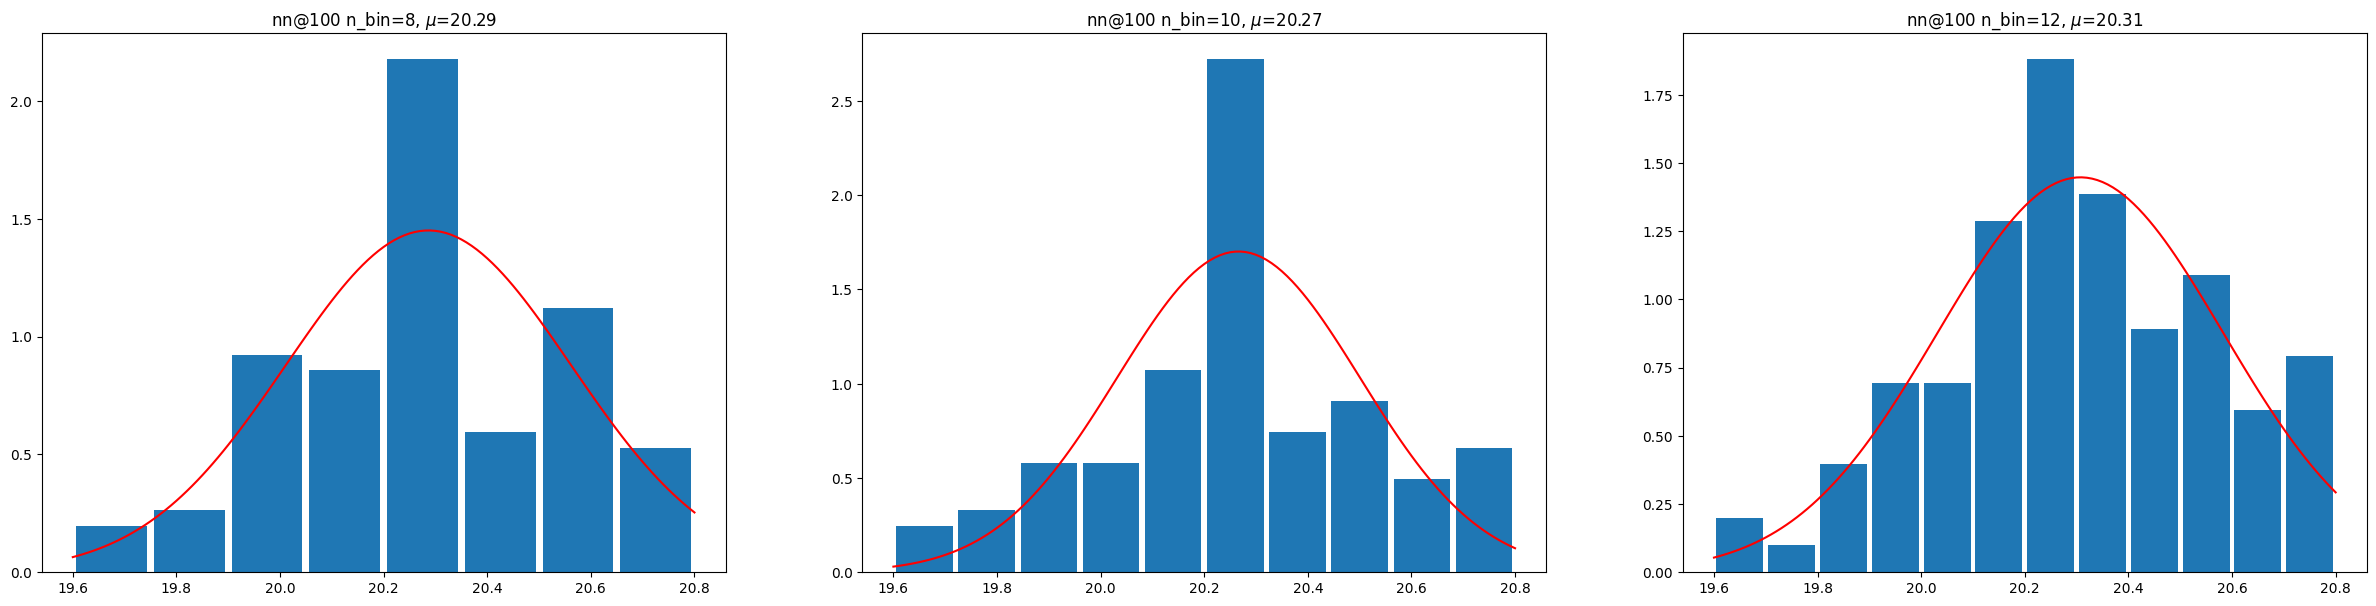

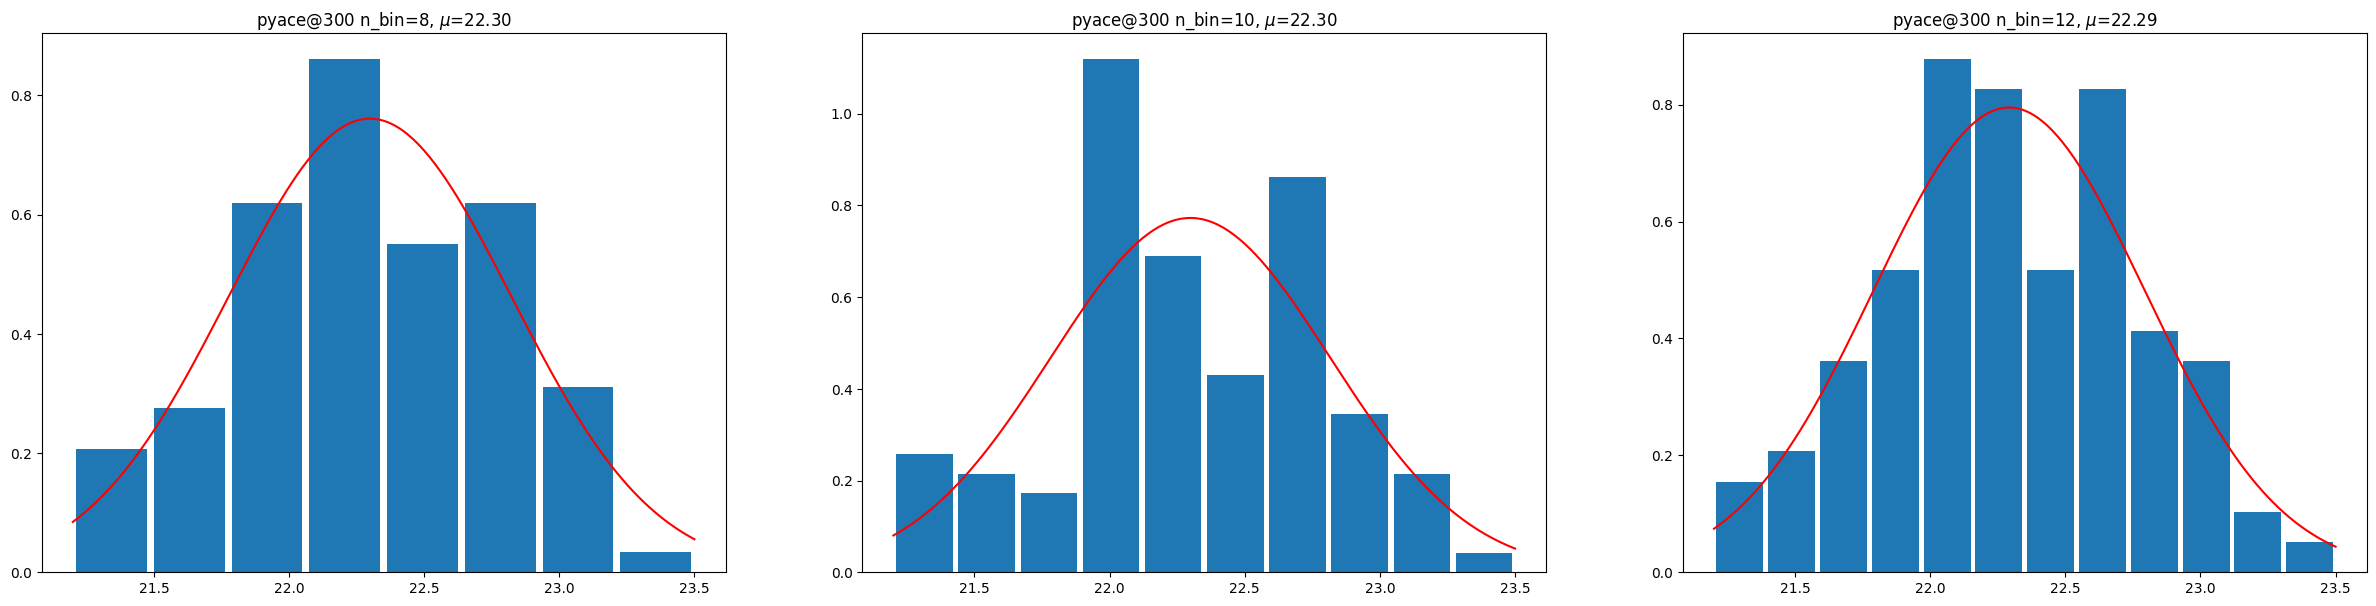

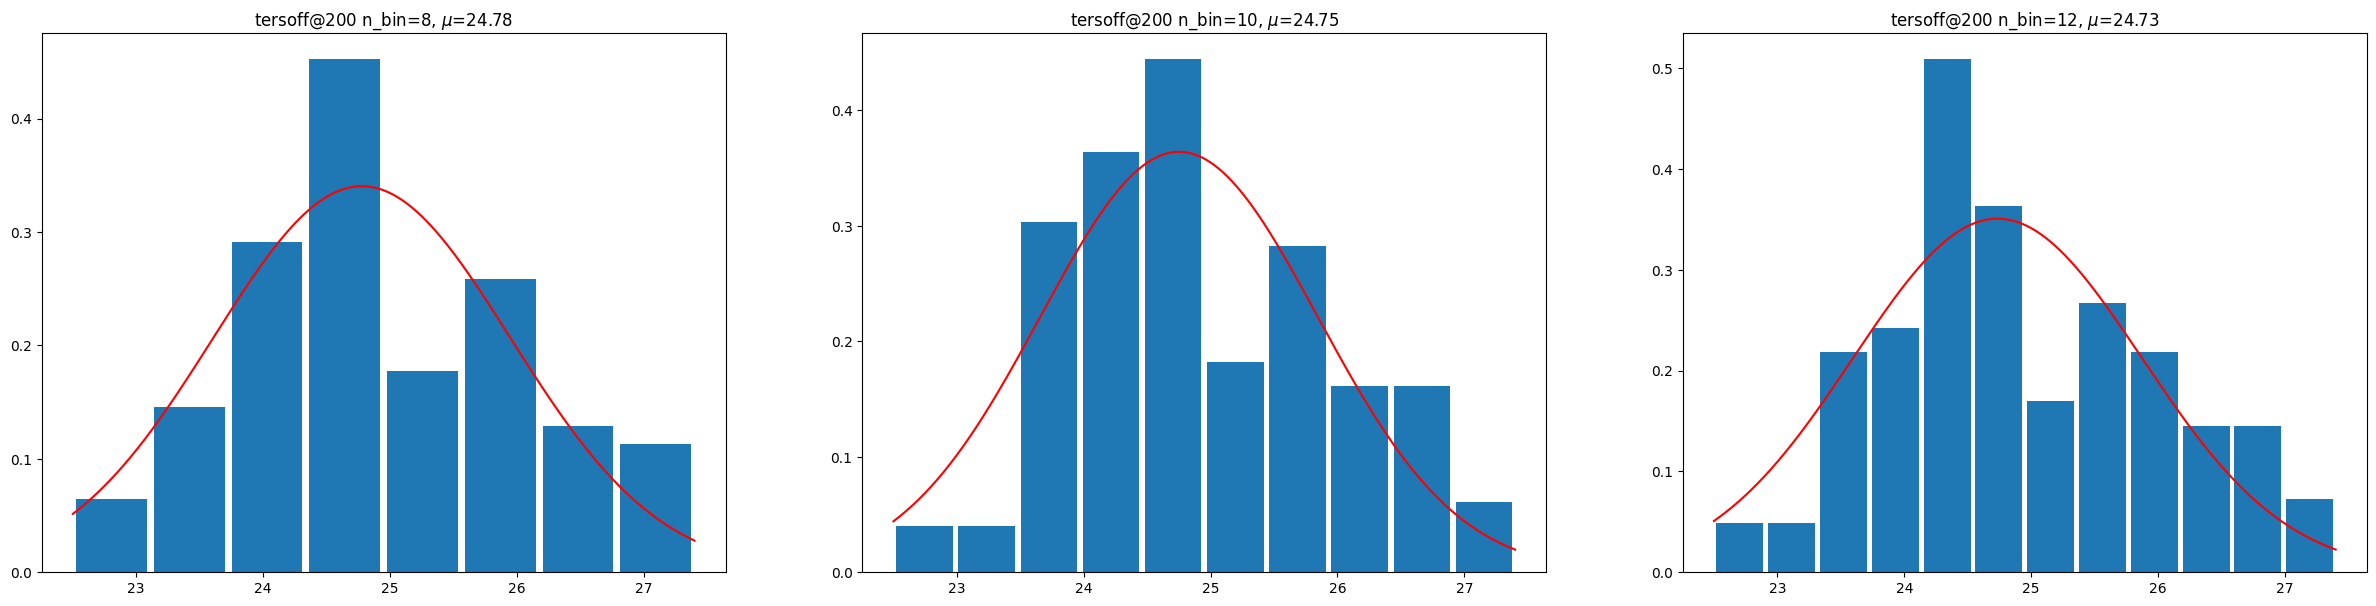

In [21]:
# Analyzation code for the results of the thermalized threshold energies, deciding on a number of bins to use

loaded_results, potentials, temps = load_all_results()

n_bins = [8, 10, 12]

for key, result in loaded_results.items():
    fig, ax = plt.subplots(1, len(n_bins), figsize=(10*len(n_bins), 7))
    for i, n_bin in enumerate(n_bins):
        pdf, bins = np.histogram(result, density=True, bins=n_bin)
        bin_centers = (bins[1:] + bins[:-1])/2 # Calculate bin centers

        bin_width = (bins[1:] - bins[:-1])[0]

        p0 = [np.mean(result), np.std(result)]

        popt, pcov = sc.optimize.curve_fit(normal, bin_centers, pdf, p0=p0)
        mu, sigma = popt[0], popt[1]

        x = np.arange(bins[0], bins[-1], 0.01)

        ax[i].bar(bin_centers, pdf, align="center", width=bin_width/1.1)
        ax[i].plot(x, normal(x, *popt), color="red")

        ax[i].set_title(f"{key} n_bin={n_bin}, $\mu$={mu:0.2f}")

    plt.show()

This process could be improved with advanced binning strategies, but this goes beyond the scope of this experiment. For now, we decide on a bin count of 8.

The last step we do in our analysis is to fit the normal distribution to the histogram of each trajectory. The plots containing the histograms are sorted by temperature. The plots below those are then comparing the probability density functions at different temperatures of each potential.

Since we expect the spread of threshold energies to increase with temperature, as lower as well as higher energies then become more likely to cause ejections, we also calculate the full width half maximum (FWHM) of each probability density function and visualize them in the last plot, which shows the FWHMs as a function of temperature for each potential.

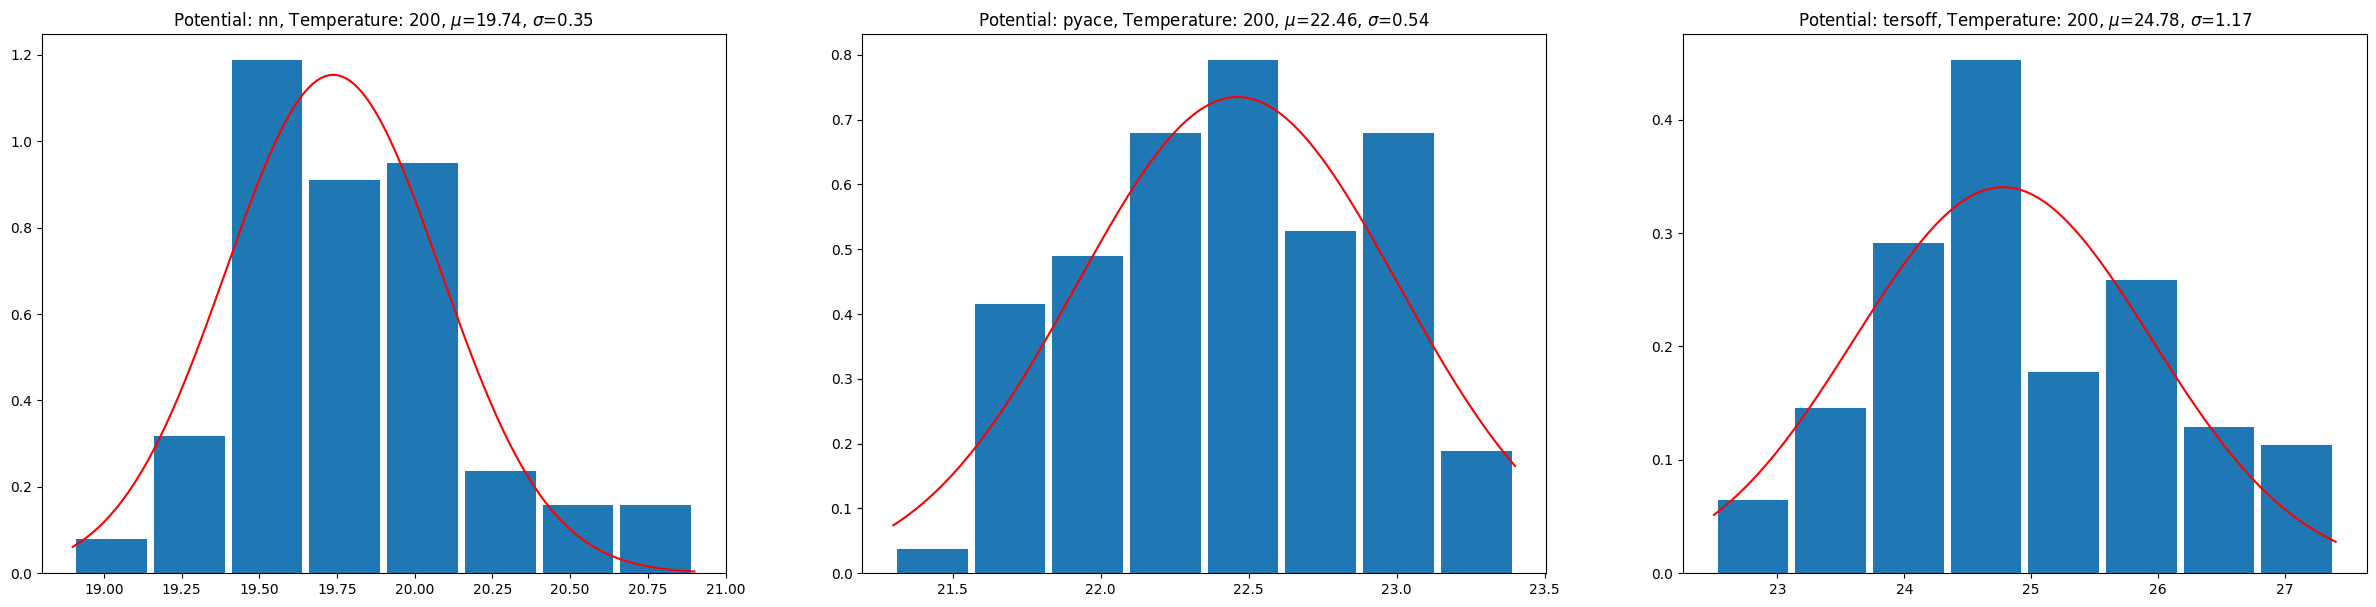

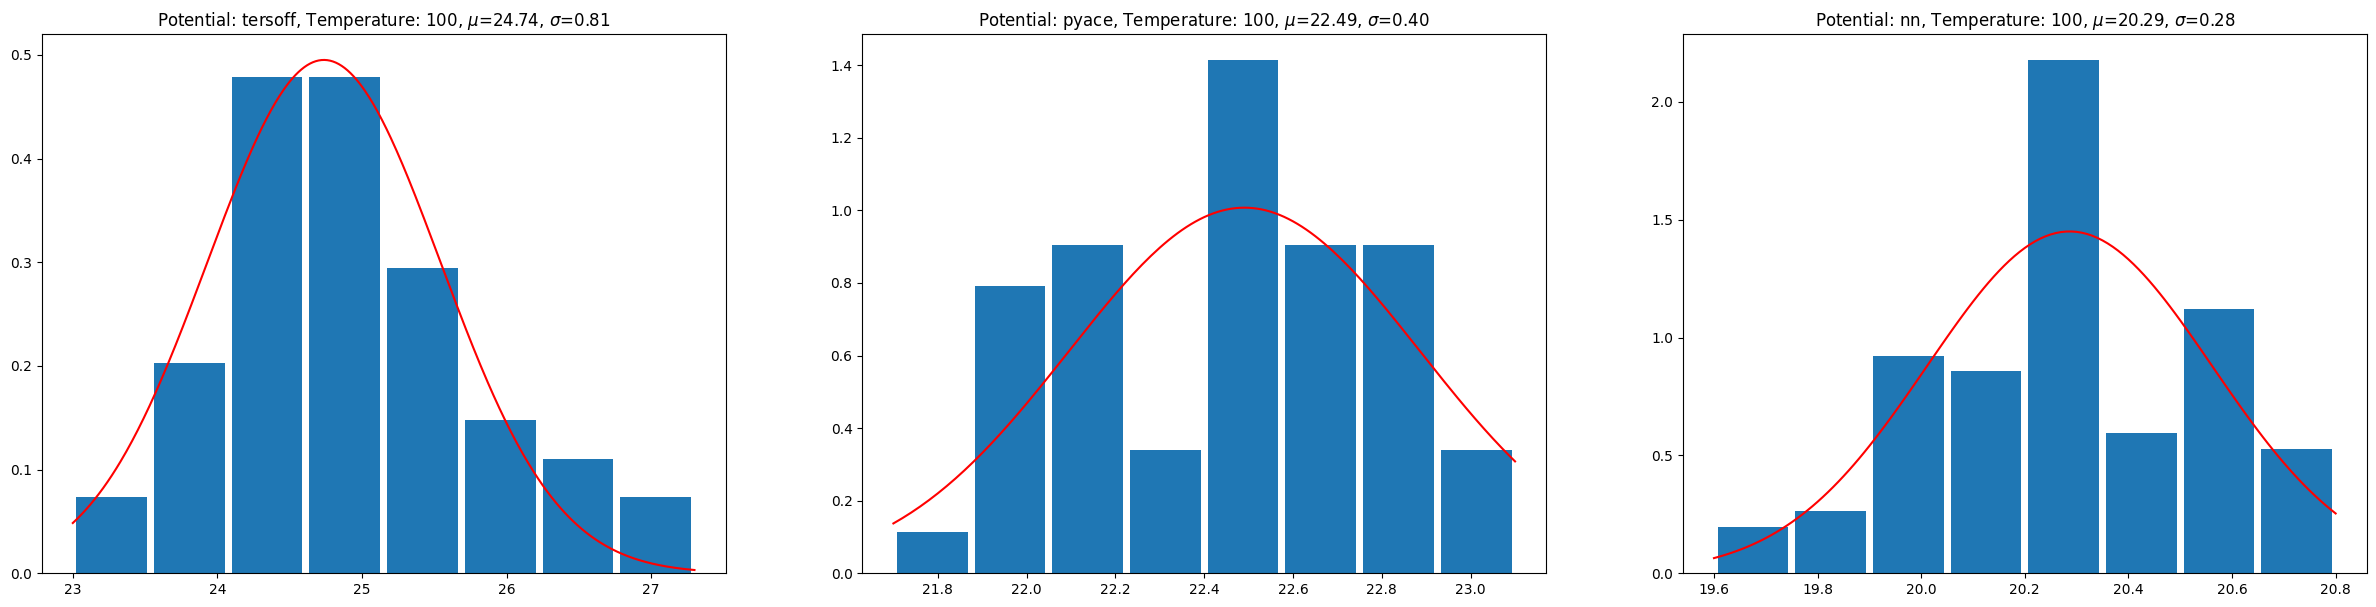

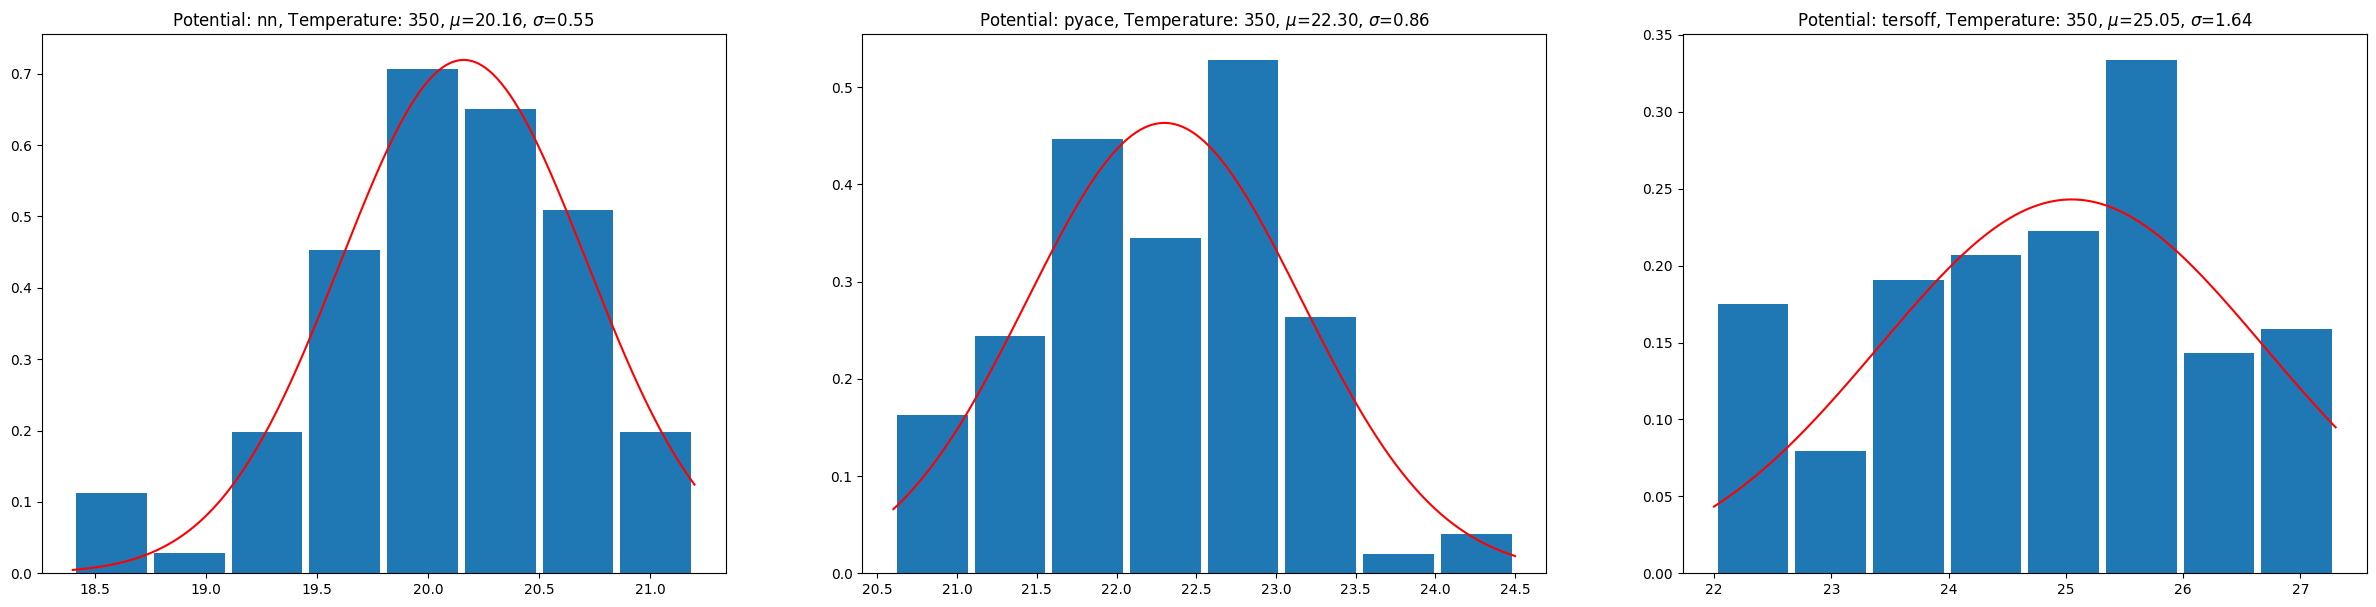

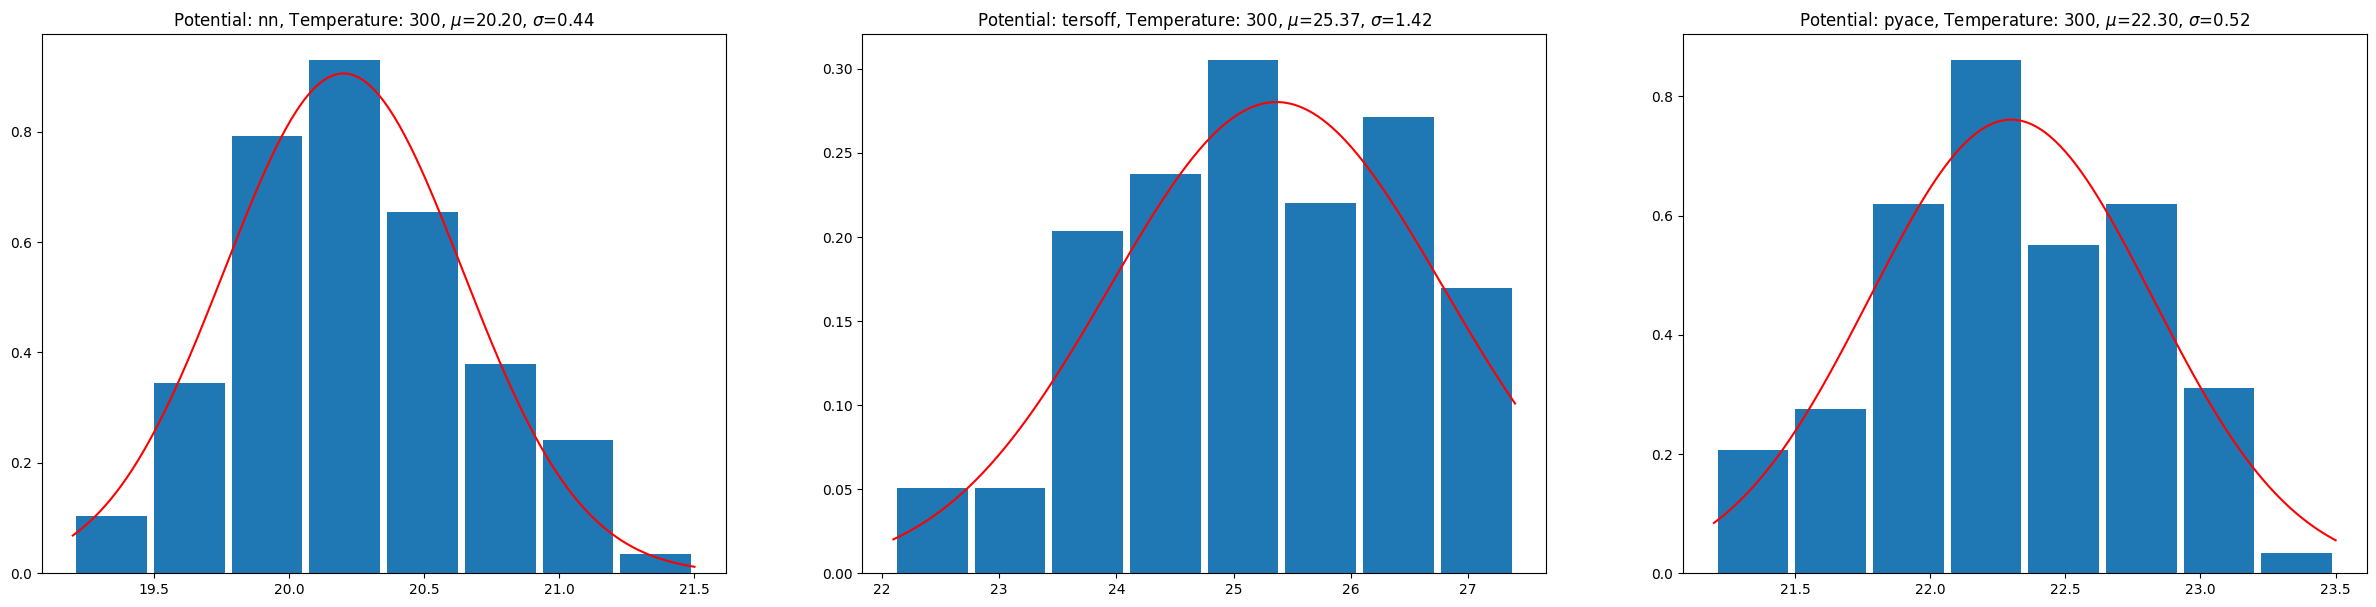

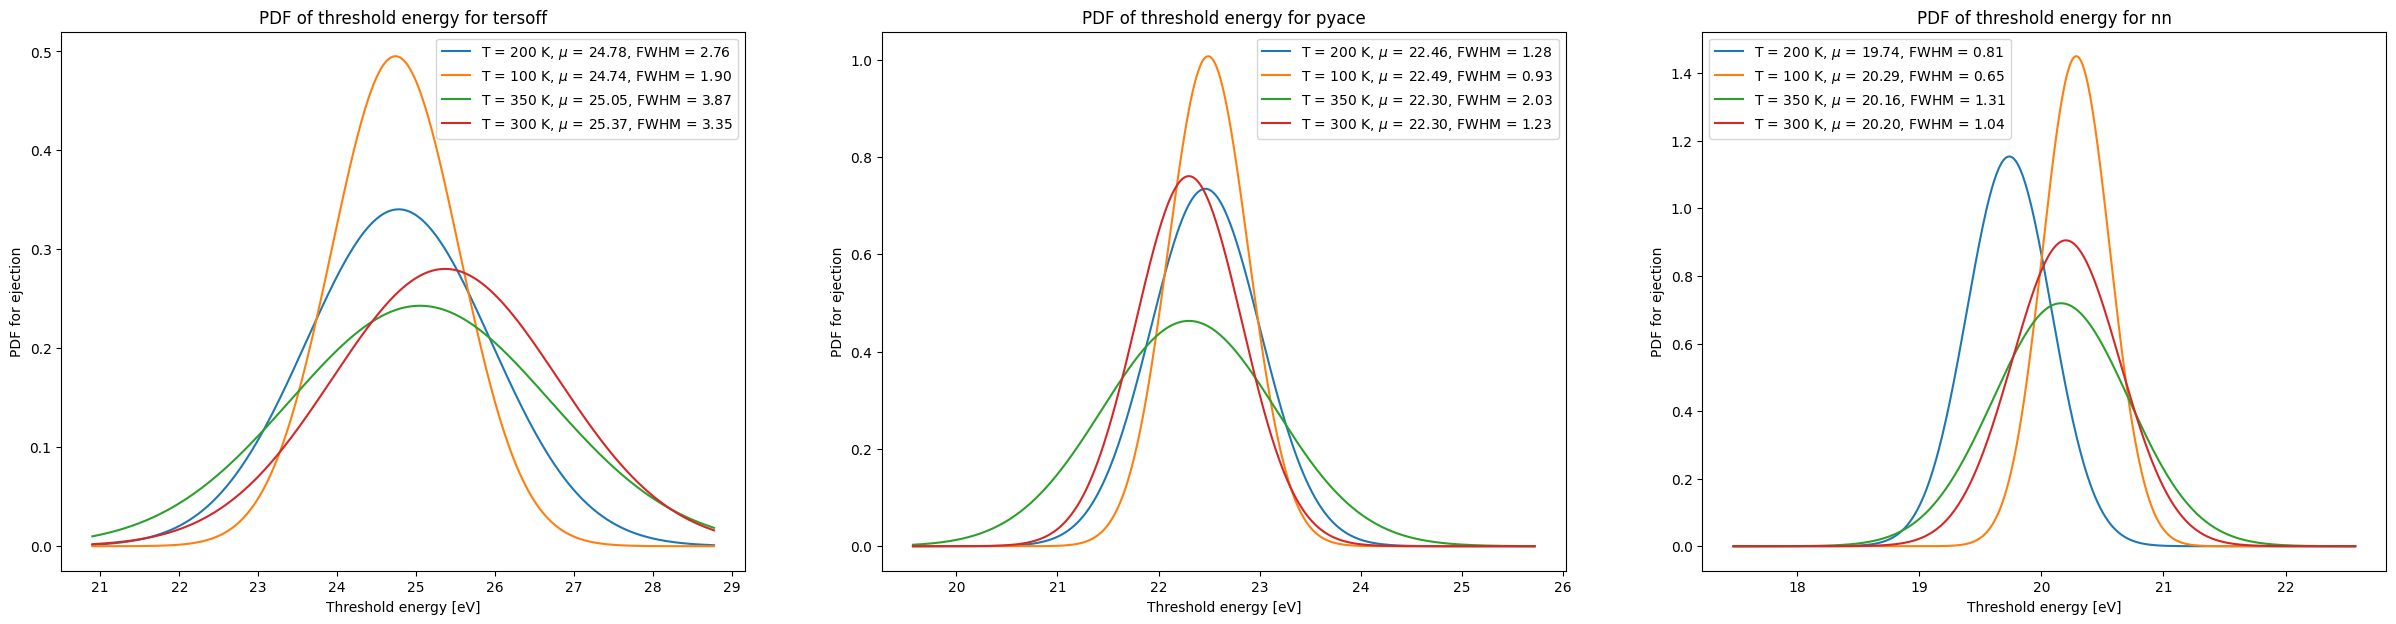

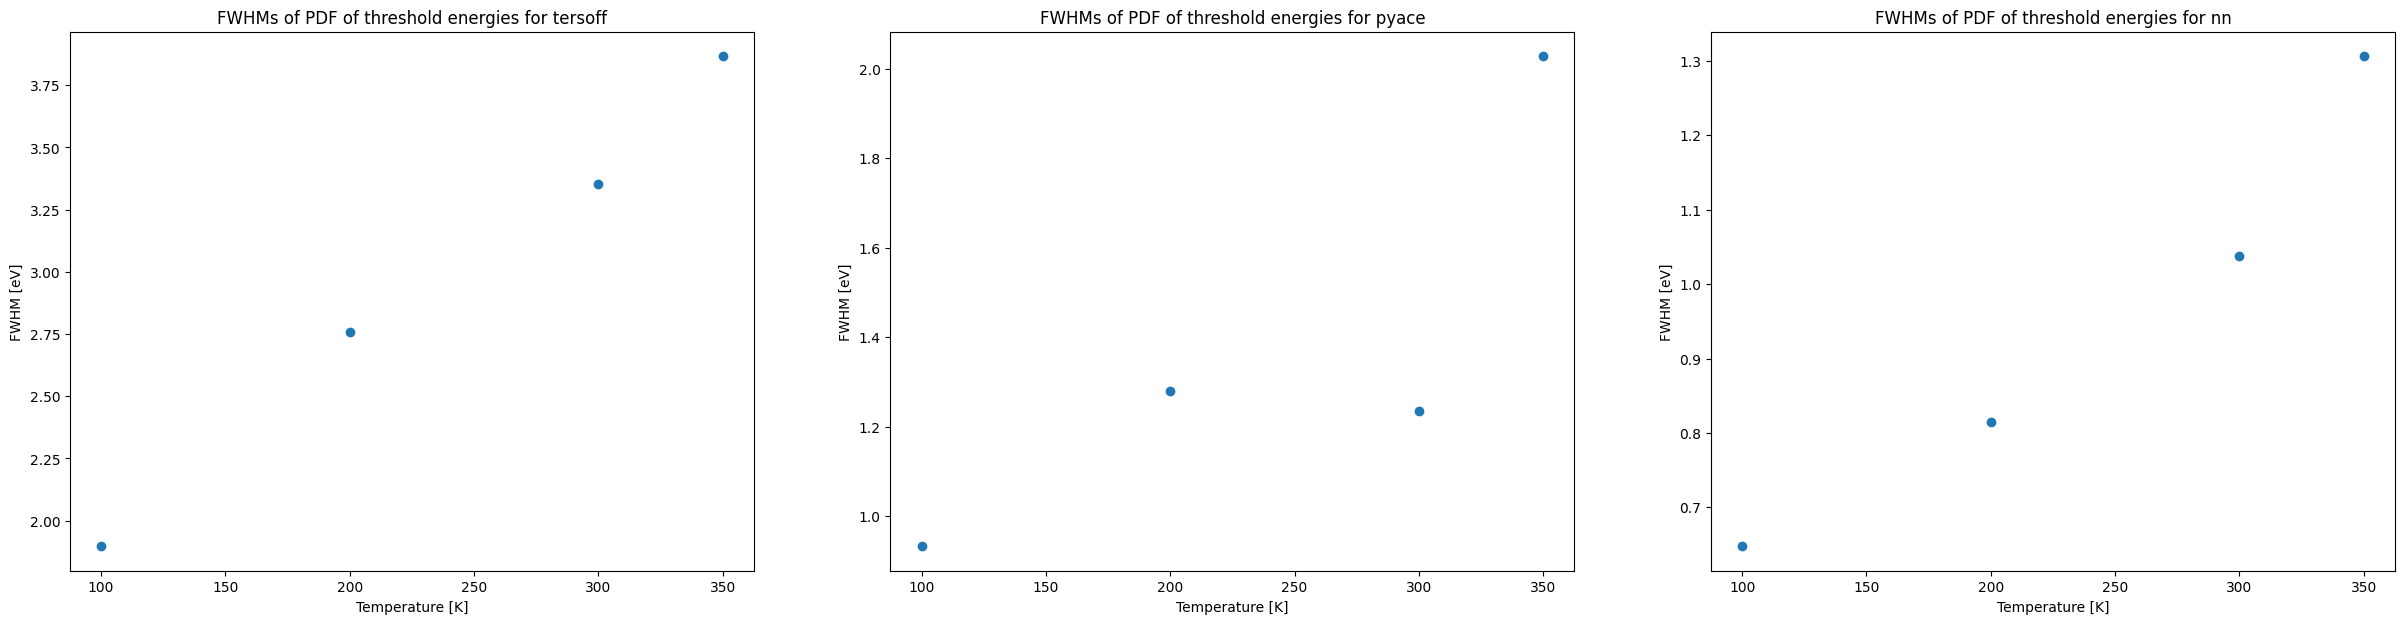

In [13]:
# Doing the plots separated by temperature for 8 bins per potential with histogram

loaded_results, potentials, temps = load_all_results()

# Organize the results by temperature
temp_results = {temp: {key.split("@")[0]: loaded_results[key] for key in loaded_results.keys() if int(key.split("@")[1]) == temp} for temp in temps}

n_bin = 8

fit_params = {potential: {} for potential in potentials} # Store the fit parameters found for later use

for temp in temp_results.keys():
    n_potentials = len(temp_results[temp].keys())
    fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))
    for i, potential in enumerate(temp_results[temp]):
        result = temp_results[temp][potential]
        pdf, bins = np.histogram(result, density=True, bins=n_bin)
        bin_centers = (bins[1:] + bins[:-1])/2

        bin_width = (bins[1:] - bins[:-1])[0]

        p0 = [np.mean(result), np.std(result)]

        popt, pcov = sc.optimize.curve_fit(normal, bin_centers, pdf, p0=p0)
        mu, sigma = popt[0], popt[1]

        fit_params[potential][temp] = (popt, bins[0], bins[-1])

        x = np.arange(bins[0], bins[-1], 0.01)

        ax[i].bar(bin_centers, pdf, align="center", width=bin_width/1.1)
        ax[i].plot(x, normal(x, *popt), color="red")

        ax[i].set_title(f"Potential: {potential}, Temperature: {temp}, $\mu$={mu:0.2f}, $\sigma$={sigma:0.2f}")

    plt.show()

# PDFs for different temperatures per potential

n_potentials = len(fit_params.keys())

fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))

for i, potential in enumerate(fit_params.keys()):
    x_min, x_max = 1000, 0
    for temp in fit_params[potential].keys(): # Find the plotting range needed to plot all PDFs of the same potential in the same plot
        params = fit_params[potential][temp]
        if params[1] < x_min:
            x_min = params[1]
        if params[2] > x_max:
            x_max = params[2]
    for temp in fit_params[potential].keys():
        params = fit_params[potential][temp]
        FWHM = 2.355*params[0][1] # Calculate FWHM

        x = np.arange(0.95*x_min, 1.05*x_max, 0.01)

        ax[i].plot(x, normal(x, *params[0]), label=f"T = {temp} K, $\mu$ = {params[0][0]:0.2f}, FWHM = {FWHM:0.2f}")
    
    ax[i].set_title(f"PDF of threshold energy for {potential}")
    ax[i].legend()
    ax[i].set_xlabel("Threshold energy [eV]")
    ax[i].set_ylabel("PDF for ejection")

plt.show()

# FWHMs per potential as a function of temperature

fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))

for i, potential in enumerate(fit_params.keys()):
    FWHMs = []
    for temp in fit_params[potential].keys():
        params = fit_params[potential][temp]
        FWHMs.append(2.355*params[0][1])

    ax[i].scatter(list(fit_params[potential].keys()), FWHMs)
    
    ax[i].set_title(f"FWHMs of PDF of threshold energies for {potential}")
    ax[i].set_xlabel("Temperature [K]")
    ax[i].set_ylabel("FWHM [eV]")

plt.show()

As one can see, the FWHMs in the last plot grow with increasing temperature, except for one data point for the pyace potential at 300 K. The average displacement threshold energies obtained from the fits are the following:

| Potential | Average displacement threshold energy with standard error |
|-----------|---------------------------------------|
| pyace     | (22.4 $\pm$ 0.1) eV                   |
| nn        | (20.1 $\pm$ 0.2) eV                   |
| tersoff   | (25.0 $\pm$ 0.2) eV                   |

Since, in the plot of the different PDFs for different temperatures, the distributions are not cetered around the same energies (especially for nn at 200 K and pyace at 300 K) and to make sure that this is not due to binning, we try another, alternative route to obtain the FWHM plots. We now directly calculate the means and FWHMs from the data, without performing any fits.

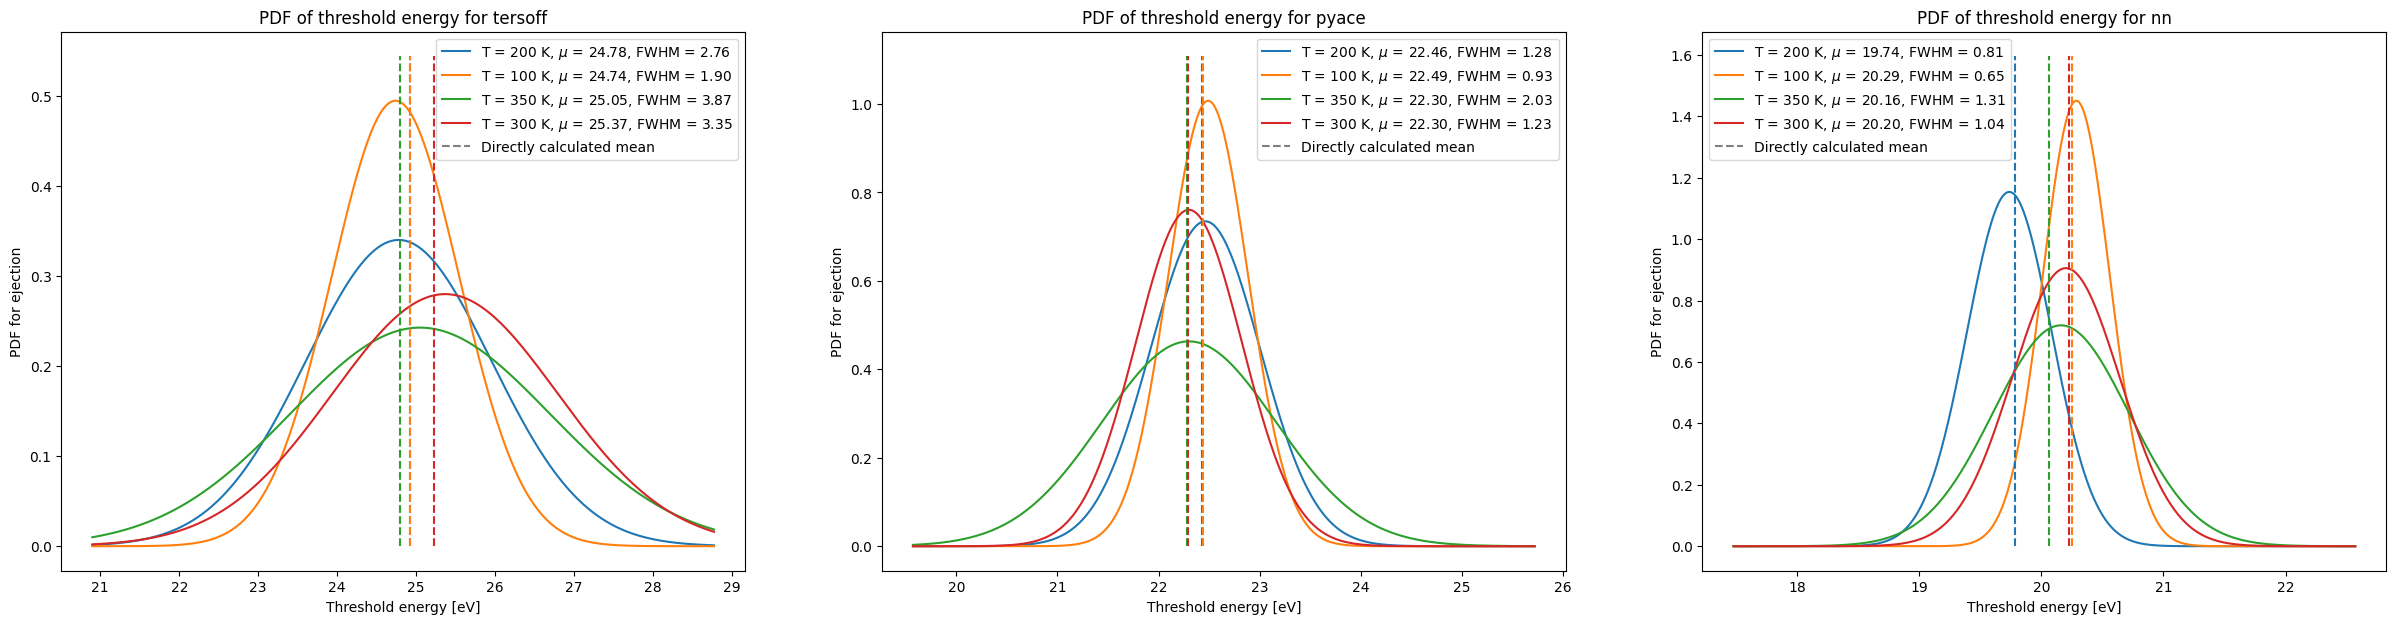

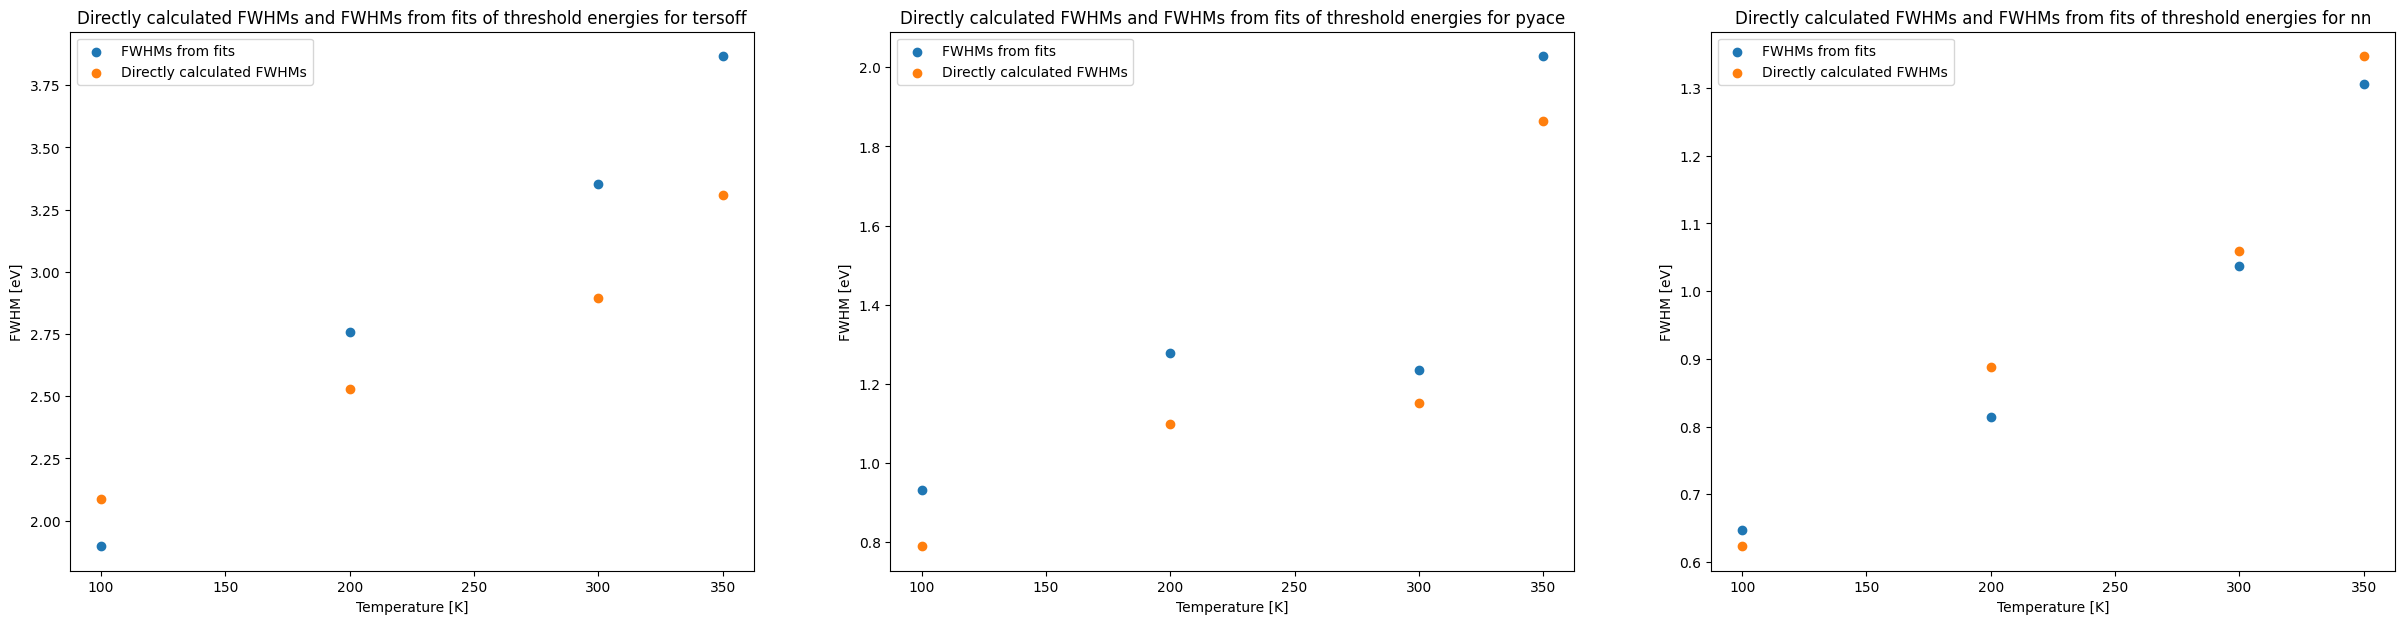

In [26]:
loaded_results, potentials, temps = load_all_results()

# Organize the results by temperature
temp_results = {temp: {key.split("@")[0]: loaded_results[key] for key in loaded_results.keys() if int(key.split("@")[1]) == temp} for temp in temps}

n_bin = 8

fit_params = {potential: {} for potential in potentials} # Store the fit parameters found for later use

for temp in temp_results.keys():
    for i, potential in enumerate(temp_results[temp]):
        result = temp_results[temp][potential]
        pdf, bins = np.histogram(result, density=True, bins=n_bin)
        bin_centers = (bins[1:] + bins[:-1])/2

        bin_width = (bins[1:] - bins[:-1])[0]

        p0 = [np.mean(result), np.std(result)]

        popt, pcov = sc.optimize.curve_fit(normal, bin_centers, pdf, p0=p0)
        mu, sigma = popt[0], popt[1]

        fit_params[potential][temp] = (popt, bins[0], bins[-1])


means_fwhms = {temp: {key.split("@")[0]: (np.mean(loaded_results[key]), 2.355*np.std(loaded_results[key])) for key in loaded_results.keys() if int(key.split("@")[1]) == temp} for temp in temps}

# PDFs for different temperatures per potential and manually computed means

n_potentials = len(fit_params.keys())

fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))

for i, potential in enumerate(fit_params.keys()):
    x_min, x_max = 1000, 0
    for temp in fit_params[potential].keys(): # Find the plotting range needed to plot all PDFs of the same potential in the same plot
        params = fit_params[potential][temp]
        if params[1] < x_min:
            x_min = params[1]
        if params[2] > x_max:
            x_max = params[2]
    colors = {} # For mean line plot
    max_value = 0 # For mean line plot range
    for temp in fit_params[potential].keys():
        params = fit_params[potential][temp]
        FWHM = 2.355*params[0][1] # Calculate FWHM

        x = np.arange(0.95*x_min, 1.05*x_max, 0.01)

        line = ax[i].plot(x, normal(x, *params[0]), label=f"T = {temp} K, $\mu$ = {params[0][0]:0.2f}, FWHM = {FWHM:0.2f}")
        colors[temp] = line[0].get_color()
        if np.max(line[0].get_data()[1]) > max_value:
            max_value = np.max(line[0].get_data()[1])
        
    for temp in fit_params[potential].keys():
        calc_mean, calc_fwhm = means_fwhms[temp][potential]
        ax[i].vlines(calc_mean, 0, 1.1*max_value, colors[temp], ls="--")
    
    ax[i].set_title(f"PDF of threshold energy for {potential}")
    ax[i].set_xlabel("Threshold energy [eV]")
    ax[i].set_ylabel("PDF for ejection")
    ax[i].vlines(calc_mean, 0, 0, color="gray", ls="--", label="Directly calculated mean")
    ax[i].legend()

plt.show()

# FWHMs per potential as a function of temperature from directly calculated FWHMs

fig, ax = plt.subplots(1, n_potentials, figsize=(10*n_potentials, 7))

for i, potential in enumerate(fit_params.keys()):
    FWHMs_direct = []
    FWHMs_pdf = []
    for temp in fit_params[potential].keys():
        FWHMs_direct.append(means_fwhms[temp][potential][1])
        params = fit_params[potential][temp]
        FWHMs_pdf.append(2.355*params[0][1])

    ax[i].scatter(list(fit_params[potential].keys()), FWHMs_pdf, label="FWHMs from fits")
    ax[i].scatter(list(fit_params[potential].keys()), FWHMs_direct, label="Directly calculated FWHMs")
    
    ax[i].set_title(f"Directly calculated FWHMs and FWHMs from fits of threshold energies for {potential}")
    ax[i].set_xlabel("Temperature [K]")
    ax[i].set_ylabel("FWHM [eV]")
    ax[i].legend()

plt.show()

In the first plot, we compare the directly computed means (dashed lines) to the PDFs obtained from the fits. The second plot is the same as its counterpart above but also includes the FWHMs directly computed from the data without fitting. The numeric results can be seen in the table below.

|  | 100 K | 100 K | 200 K | 200 K | 300 K | 300 K | 350 K | 350 K |
|---|---|---|---|---|---|---|---|---|
| **Potential** | **Mean** | **FWHM** | **Mean** | **FWHM** | **Mean** | **FWHM** | **Mean** | **FWHM** | 
| tersoff | 24.92 eV | 2.09 eV | 24.92 eV | 2.53 eV | 25.23 eV | 2.89 eV | 24.79 eV | 3.31 eV | 
| pyace | 22.44 eV | 0.79 eV | 22.43 eV | 1.10 eV | 22.30 eV | 1.15 eV | 22.29 eV | 1.86 eV | 
| nn | 20.25 eV | 0.62 eV | 19.78 eV | 0.89 eV | 20.23 eV | 1.06 eV | 20.06 eV | 1.35 eV | 

Also, the displacement threshold energies for each potential averaged over the different temperatures are displayed in the table below.

| Potential | Average displacement threshold energy (directly calculated) |
| --- | --- |
| tersoff | (25.0 $\pm$ 0.1) eV |
| pyace | (22.4 $\pm$ 0.1) eV |
| nn | (20.1 $\pm$ 0.1) eV |

# Discussion

In this experiment, we investigated the behaviour of graphene after momentum transfer to one of the lattice atoms using different inter-atomic potentials, both for the static-lattice approximation as well as for thermalized systems.

## Comparison of results to previous studies

In a previous study [12], Susi et al. used DFT molecular dynamics to determine the displacement threshold energy for thermalized graphene systems and obtained results in an energy range of [21.25 eV; 21.375 eV], which they found to overestimate the result of 21,14 eV obtained from experiments. Nevertheless, this gives us a basis to compare our results to.

The potential that comes closest to the experimental value is the nn potential, followed by pyace. Tersoff generally yielded the worst results when compared to previous findings. Concerning the DFT-MD results, pyace is closest to the range mentioned above, with nn in second place. It has to be noted that, although nn comes closer to the experimental result, it behaves more unphysical than pyace as discussed in the static-lattice simulations, since it drops to a negative force earlier and more severely than pyace. Therefore, the nn potential should be handled with caution.

Another study done by Chirita Mihaila et al. [13] used DFT tight-binding based MD to investigate the displacement threshold of thermalized graphene. In their article, they produced a similar plot to the FWHM plot we obtained at the end of our experiment. Comparing both plots, none of our potentials managed to reproduce these results, with pyace and nn coming closest. It has to be pointed out that this could partially be because our sample size was more than 4 times smaller than the one in [13] and that pyace, apart from the FWHM value at 350 K, comes somewhat near the study's results. Also, it is worth mentioning that the small cell size of 6 $\times$ 6 we used for the thermal simulations yields high variability in the system's temperature, which, combined with the rather small sample size, could negatively impact the accuracy of the results.

## Fits of histograms vs. directly computed parameters

As mentioned at the end of the previous chapter, we wanted to rule out any problems caused by binning. Therefore, in addition to obtaining the mean threshold energies and FWHMs through fits, we computed these parameters directly from the data.

As one can see from the second to last plot, the PDFs are not centered around the same energy, which is not physical. This is not a result of bad binning, as is shown by the dashed lines (directly computed means) also not being centered on the same energies. We suspect that this is due to the rather small sample size. However, the last plot, which compares the FWHMs obtained through the two different approaches, shows that the FWHMs computed directly seem to be more accurate than the ones resulting from the fits, judging by the fact that, for pyace at 300 K, the FWHM is larger than at 200 K as we expect. In general, the FWHM plots exhibit the same behaviour for both approaches.

Also, it should be mentioned that the displacement threshold energies averaged over the different temperatures are unchanged between approaches.

## Possible improvements

As mentioned above, a larger sample and/or cell size would surely yield better results. For this, modifications to the simulation code would be necessary to increase performance. For example, a full simulation in the pyace potential for a single temperature (we used four of those) and a cell size of 6 $\times$ 6 took roughly 2,5 to 3 hours. The obvious improvement would be to use multiprocessing, which would be rather easy to implement, since each of the 101 ejection simulations per potential per temperature runs completely independent of the others. In case of our numeric example of pyace with a single-core runtime of 3 hours and assuming 8 cores working in parallel, this would reduce the simulation time to about 20 minutes. Further improvements could be made by running the simulations on a modern desktop processor instead of on a notebook.

# References

[1] Gross, R. and Marx, A. (2022) Festkörperphysik. 4., akt. Aufl. München Wien: De Gruyter Oldenbourg.

[2] Susi, T., Meyer, J. C., & Kotakoski, J. (2019). Quantifying transmission electron microscopy irradiation effects using two-dimensional materials. Nature Reviews Physics, 1(6), 397–405. doi:10.1038/s42254-019-0058-y

[3] Mishin, Y. (2021). Machine-learning interatomic potentials for materials science. Acta Materialia, 214, 116980. https://doi.org/10.1016/j.actamat.2021.116980

[4] Tersoff, J. (1988). Empirical interatomic potential for carbon, with application to amorphous carbon. Physical review letters, 61(25), 2879–2882. https://doi.org/10.1103/PhysRevLett.61.2879

[5] Rowe, P., Deringer, V. L., Gasparotto, P., Csányi, G. & Michaelides, A. (2020). An accurate and transferable machine learning potential for carbon. The Journal of chemical physics, 153(3), 34702. https://doi.org/10.1063/5.0005084

[6] Bartók, A. P., Payne, M. C., Kondor, R. & Csányi, G. (2010). Gaussian Approximation Potentials: the accuracy of quantum mechanics, without the electrons. Physical Review Letters, 104(13). https://doi.org/10.1103/PhysRevLett.104.136403

[7] Wen, M. & Tadmor, E. B. (2019). Hybrid neural network potential for multilayer graphene. Physical Review B, 100(19). https://doi.org/10.1103/PhysRevB.100.195419

[8] Bochkarev, A., Lysogorskiy, Y., Menon, S., Qamar, M., Mrovec, M. & Drautz, R. (2022). Efficient parametrization of the atomic cluster expansion. Physical Review Materials, 6(1). https://doi.org/10.1103/PhysRevMaterials.6.013804

[9] Drautz, R. (2019). Atomic cluster expansion for accurate and transferable interatomic potentials. Physical Review B, 99(1). https://doi.org/10.1103/PhysRevB.99.014104

[10] Hjorth Larsen, A., Jørgen Mortensen, J., Blomqvist, J., Castelli, I. E., Christensen, R., Dułak, M., … Jacobsen, K. W. (2017). The atomic simulation environment—a Python library for working with atoms. Journal of Physics: Condensed Matter, 29(27), 273002. doi:10.1088/1361-648x/aa680e

[11] Tadmor, E. B., Elliott, R. S., Sethna, J. P., Miller, R. E. & Becker, C. A. (2011). The potential of atomistic simulations and the knowledgebase of interatomic models. JOM, 63(7), 17. https://doi.org/10.1007/s11837-011-0102-6

[12] Susi, T., Hofer, C., Argentero, G., Leuthner, G. T., Pennycook, T. J., Mangler, C., … Kotakoski, J. (2016). Isotope analysis in the transmission electron microscope. Nature Communications, 7(1). doi:10.1038/ncomms13040

[13] Chirita Mihaila, A. I., Susi, T., & Kotakoski, J. (2019). Influence of temperature on the displacement threshold energy in graphene. Scientific Reports, 9(1). doi:10.1038/s41598-019-49565-4

[14] Ortner, C. (2023). On the Atomic Cluster Expansion: interatomic potentials and beyond. doi:10.25950/C7F24234

[15] Lysogorskiy, Y., Bochkarev, A., Mrovec, M., & Drautz, R. (2023). Active learning strategies for atomic cluster expansion models. Phys. Rev. Mater., 7, 043801. doi:10.1103/PhysRevMaterials.7.043801